In [1]:
import os
import random
import sys

import time

import yaml

from pathlib import Path

from copy import deepcopy

import numpy as np
import math

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

from torchvision.io import read_image, ImageReadMode
import torchvision

import albumentations as A
from albumentations.pytorch import ToTensorV2

from pytorch_model_summary import summary

from fLossFunctions import v8DetectionLoss
from fValidation import v8DetectionValidator

from collections import defaultdict
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt

import pandas as pd

In [2]:
params = {
    "data_dir": '/media/pipeh/Data/Datasets/coco', #"/media/pipeh/Data/Datasets/coco", # "D:/Datasets/coco",
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "save_pth": "checkpoint/coco",
    "batch_size": 32,
    "epochs": 170,
    "img_size": 320,
    "mosaic": True,
    "mixup_thr": 0.8,
    "reg_max": 4,
}

## Build datasets

In [3]:
class DetectionDataset(Dataset):
    """
    SuperClass with pytorch Dataset methods to manage an object detection dataset, loading its images
    with its labels and applying the basic data augmentation pipelines.
    
    Args:
        args (dict): script hyper parameters and arguments.
        partition (string): Dataset mode for train or test partition and data augmentations.
        transform (Albumentation Compose): Data augmentation pipeline for images in train or test.
    
    Attributes:
        mode (String): dataset mode: train or test.
        subset_images (string): image dataset subset folder name.
        subset_labels (string): labels dataset subset folder name.
        mosaic (bool): flag if use mosaic images.
        transform (Albumentation Compose): data augmentation pipeline.
        img_size (int): image size w,h to resize images.
        file_ids (list): names of the files of the images.
        
    Methods:
        __len__(self): return the lenght of dataset subset.
        __getitem__(self, idx): return a batch composed by images, its bboxes and classes labels for each box, depending if
                                mixup augmentation is true.
        load_image(self, idx): load and return a single sample composed by an image, its bboxes and classes labels for each box.
    """
    
    def __init__(self, args, partition=None, transform=None):
        super(DetectionDataset, self).__init__()
        self.params = args
        self.mode = partition
        self.img_size = args["img_size"]
        self.mosaic = args["mosaic"]
        self.transform = transform
        
        self.subset_images = self.subset_labels = ''
        if self.mode == 'train':
            if self.mosaic == True:
                self.subset_images += 'train2017_mosaic'
                self.subset_labels += 'train2017_mosaic'
            else:
                self.subset_images += 'train2017'
                self.subset_labels += 'train2017_coco'                
        else:
            self.subset_images += 'val2017'
            self.subset_labels += 'val2017_coco'
        
        self.file_ids = os.listdir(f'{self.params["data_dir"]}/labels/{self.subset_labels}')
    
    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, idx):
        image, bboxes, labels = self.load_image(idx)
        return image, bboxes, labels
        
    def load_image(self, idx):
        file_name = self.file_ids[idx]
        bboxes = []
        labels = []
        image = read_image(f'{self.params["data_dir"]}/images/{self.subset_images}/{file_name[:-4]}.jpg', ImageReadMode.RGB)
        with open(f'{self.params["data_dir"]}/labels/{self.subset_labels}/{file_name}', 'r') as f:
            for line in f.readlines():
                line_data = list(map(float, line.strip().split()))
                labels.append(int(line_data[0]))
                bboxes.append(line_data[1:])
        transformed = self.transform(image=np.array(image.permute(1,2,0), np.float32) / 255., 
                                     bboxes=bboxes, 
                                     class_labels=labels)
        image = transformed['image']
        bboxes = transformed['bboxes']
        labels = transformed['class_labels']
        bboxes = torch.tensor(bboxes)
        labels = torch.tensor(labels).unsqueeze(dim=-1)
        return image, bboxes, labels

In [4]:
class ProcessBatch(object):
    """
    Preprocessing class that takes a list of tuples of images, bboxes and labels and arranges them as a batch of
    given lenght, and applies MixUp augmentation if a random probability surprass a threshold.
    
    Attributes:
        n_max_boxes (int): maxium number of zeros batch padding.
        thr (float): threshold to apply mixup augmentation
        
    Methods_
        __call__(self, batch): return a batched set of images, bounding boxes and labels.
        pad_batch(self, batch): return a batched set of images, bounding boxes and labels.
        mixup_batch(self, batch): return a batched set of images, bounding boxes and labels with MixUp augmentation
                                with its same batch but randomly shuffled.
                                
    """
    def __init__(self, thr=0.5):
        self.n_max_boxes = 128
        self.n_max_boxes_mixup = 256
        self.thr = thr
        
    def __call__(self, batch):
        if random.random() < self.thr:
            images, bboxes, labels = self.mixup_batch(batch)
            return images, bboxes, labels
        else:
            images, bboxes, labels = self.normal_batch(batch)
            return images, bboxes, labels

    def normal_batch(self, batch):
        img_tuple, bboxes_tuple, labels_tuple = zip(*batch)
        images  = torch.stack(list(img_tuple), dim=0)
        bboxes = torch.tensor([])
        labels = torch.tensor([])
        for box,label in zip(bboxes_tuple, labels_tuple):
            box, label = self.pad_batch(box, label, self.n_max_boxes)
            bboxes = torch.cat([bboxes, box.unsqueeze(0)], dim=0)
            labels = torch.cat([labels, label.unsqueeze(0)], dim=0)
        return images, bboxes, labels
    
    def mixup_batch(self, batch):
        img_x, bboxes_x, labels_x = zip(*batch)
        batch = list(batch)
        batch.append(batch.pop(0))
        img_y, bboxes_y, labels_y = zip(*batch)
        img_x  = torch.stack(list(img_x), dim=0)
        img_y  = torch.stack(list(img_y), dim=0)
        alpha = (0.6 - 0.4) * torch.rand(img_x.size(0), 1, 1, 1) + 0.4
        img = alpha * img_x + (1 - alpha) * img_y
        bboxes = torch.tensor([])
        labels = torch.tensor([])
        for boxA,boxB,labelA,labelB in zip(bboxes_x, bboxes_y,labels_x, labels_y):
            box = torch.cat([boxA, boxB], dim=0)
            label = torch.cat([labelA, labelB], dim=0)
            box, label = self.pad_batch(box, label, self.n_max_boxes_mixup)
            bboxes = torch.cat([bboxes, box.unsqueeze(0)], dim=0)
            labels = torch.cat([labels, label.unsqueeze(0)], dim=0)
        return img, bboxes, labels
    
    def pad_batch(self, bboxes, labels, nmax):
        bs = bboxes.shape[0]
        n = nmax - bs
        if n>0:
            bboxes = torch.cat([bboxes, torch.zeros(n,4)])
            labels = torch.cat([labels, torch.zeros(n,1)])
        elif n<0:
            bboxes = bboxes[:nmax]
            labels = labels[:nmax]
        return bboxes, labels

In [5]:
def build_dataloader(args, transforms):
    """
    Function to build dataset given a directory path and a set of transforms pipeline.
    
    Args:
        args (dict): script hyper parameters and arguments.
        transforms (dict): Different data augmentation pipelines for images in train or test.
        
    Return:
        dataset (Dataset): the builded dataset of a given subset.
        dataloader (Dataloader): the dataloader method for the dataset.
    """
    dataset = dict()
    dataloader = dict()
    if args["mosaic"] == True:
        transform = transforms["mosaic"]
    else:
        transform = transforms["non_mosaic"]
    for x in ['train', 'val']:
        dataset[x] = DetectionDataset(
            args,
            partition=x,
            transform=transform[x]
        )
        if x == 'train':
            preprocces_batch = ProcessBatch(thr=args["mixup_thr"])
        else:
            preprocces_batch = ProcessBatch(thr=0.)            
        dataloader[x] = DataLoader(
            dataset[x],
            batch_size=args["batch_size"],
            collate_fn=preprocces_batch,
            num_workers=4,
            shuffle=True,
        )    
    return dataset, dataloader

In [6]:
data_transform = dict()

data_transform['mosaic'] = {
    'train': A.Compose([
        A.RandomSizedCrop (min_max_height=(params['img_size'],params['img_size']*4), height=params['img_size'], width=params['img_size'], p=1.0),
        A.ColorJitter (hue=0.3, p=0.5),
        A.HorizontalFlip (p=0.5),
        ToTensorV2 (),
    ], bbox_params=A.BboxParams(format='coco',
                                min_area=80.0,
                                min_visibility=0.2,
                                label_fields=['class_labels'])),
    'val': A.Compose([
        A.Resize (params['img_size'], params['img_size']),
        ToTensorV2 (),
    ], bbox_params=A.BboxParams(format='coco',
                                label_fields=['class_labels'])),
}

data_transform['non_mosaic'] = {
    'train': A.Compose([
        A.Resize (params['img_size'], params['img_size']),
        A.ColorJitter (hue=0.3, p=0.5),
        A.HorizontalFlip (p=0.5),
        ToTensorV2 (),
    ], bbox_params=A.BboxParams(format='coco',
                                min_area=0.0,
                                min_visibility=0.0,
                                label_fields=['class_labels'])),
    'val': A.Compose([
        A.Resize (params['img_size'], params['img_size']),
        ToTensorV2 (),
    ], bbox_params=A.BboxParams(format='coco',
                                label_fields=['class_labels'])),
}

In [7]:
dataset, dataloader = build_dataloader(params, data_transform)
dataset_sizes = {x: len(dataset[x]) for x in ['train','val']}
print(f"dataset_sizes {dataset_sizes}")

with open(f'{params["data_dir"]}/coco.yaml') as f:
    classes = yaml.safe_load(f)['names']
nclasses = len(classes)
print(f'number of classes: {nclasses} \nclasses: {[v for x,v in classes.items()]}')

dataset_sizes {'train': 29316, 'val': 4952}
number of classes: 80 
classes: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [8]:
def visualize_coco_bbox(img, bbox, class_name, thickness=2):
    """ Draw a single bounding box on the image. """
    BOX_COLOR = (255, 0, 0) # Red
    TEXT_COLOR = (255, 255, 255) # White

    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=TEXT_COLOR, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img

In [9]:
def visualize_dataset(dataloader, category_id_to_name):
    """
    Shows a single image with its corresponding labels for the given dataloader
    dataset method.
    
    Args:
        dataloader (Dataloader): dataloader of the dataset subset to extract sample.
        category_id_to_name (dict): name of each classes corresponding to the label index.
    """
    image, bboxes, category_ids = next(iter(dataloader))
    image = image[0].unsqueeze(0)
    bboxes = bboxes[0].unsqueeze(0)
    category_ids = category_ids[0].unsqueeze(0)
    mask_gt = bboxes.sum(2, keepdim=True).gt_(0)
    bs = bboxes.shape[0]
    bboxes = bboxes[mask_gt.expand(-1, -1, 4).bool()].view(bs, -1, 4)
    category_ids = category_ids[mask_gt.bool()].view(bs, -1, 1)
    img = image[0].permute(1,2,0).numpy().copy()
    for bbox, category_id in zip(bboxes.numpy()[0], category_ids.numpy()[0]):
        class_name = category_id_to_name[category_id[0]]
        img = visualize_coco_bbox(img, bbox, class_name)
    plt.figure()
    plt.axis('off')
    plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


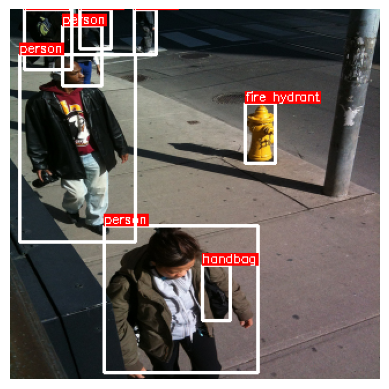

In [10]:
visualize_dataset(dataloader['val'], classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


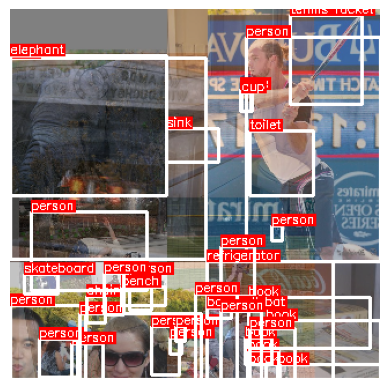

In [11]:
visualize_dataset(dataloader['train'], classes)

## Build detection model

In [12]:
class ConvModule(nn.Module):
    """ 
    Convolutional block composed of conv->batchnorm->relu. 
    """
    def __init__(self, cin=1, cout=1, k=1, s=1, p=0, device='cpu'):
        super(ConvModule, self).__init__()
        self.conv = nn.Conv2d(cin, cout, (k, k), stride=s, padding=p, bias=False).to(device)
        self.bn = nn.BatchNorm2d(cout, eps=0.001, momentum=0.03, affine=True, track_running_stats=True).to(device)
        self.silu = nn.SiLU(inplace=True).to(device)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.silu(x)
        return x

In [13]:
class Bottleneck(nn.Module):
    """ 
    Bottleneck block componsed of conv->conv->residual connection. 
    """
    def __init__(self, c=1, shortcut=False, device='cpu'):
        super(Bottleneck, self).__init__()
        self.conv1 = ConvModule(cin=c, cout=c//2, k=3, s=1, p=1, device=device)
        self.conv2 = ConvModule(cin=c//2, cout=c, k=3, s=1, p=1, device=device)
        self.shortcut = shortcut

    def forward(self, x):
        xin = x
        x = self.conv1(x)
        x = self.conv2(x)
        if self.shortcut==True:
            x = xin + x
            return x
        return x

In [14]:
class C2f(nn.Module):
    """ 
    C2f module (cross-stage partial bottleneck with two convolutions) which combines 
    high-level features with contextual information to improve detection accuracy. 
    """
    def __init__(self, cin=1, cout=1, depth=1, device='cpu'):
        super(C2f, self).__init__()
        self.cout = cout
        self.depth = depth
        self.convmodule1 = ConvModule(cin=cin, cout=cout, k=1, s=1, p=0, device=device)
        self.bottleneck = []
        for _ in range(depth):
            self.bottleneck.append(Bottleneck(c=self.cout//2, shortcut=True, device=device))
        cin = cout//2 * (depth+2)
        self.convmodule2 = ConvModule(cin=cin, cout=cout, k=1, s=1, p=0, device=device)
        
    def forward(self, x):
        x1 = self.convmodule1(x)
        x1_1, x1_2 = torch.split(x1, self.cout//2, dim=1)
        x3 = torch.cat([x1_1, x1_2],dim=1)
        for i in range(len(self.bottleneck)):
            x2 = self.bottleneck[i](x1_2)
            x3 = torch.cat([x3, x2], dim=1)
            x1_2 = x2
        x = self.convmodule2(x3)
        return x

In [15]:
class SPPF(nn.Module):
    """ 
    Spatial pyramid pooling fast module (SPPF) layer accelerates computation 
    by pooling features into a fixed-size map. 
    """
    def __init__(self, c=1, device='cpu'):
        super(SPPF, self).__init__()
        self.conv1 = ConvModule(cin=c, cout=c, k=1, s=1, p=0, device=device)
        self.mp1 = nn.MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False).to(device)
        self.mp2 = nn.MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False).to(device)
        self.mp3 = nn.MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False).to(device)
        self.conv2 = ConvModule(cin=c*4, cout=c, k=1, s=1, p=0, device=device)
        
    def forward(self, x):
        x = self.conv1(x)
        x1 = self.mp1(x)
        x2 = self.mp2(x1)
        x3 = self.mp3(x2)
        x = torch.cat([x, x1, x2, x3], dim=1)
        x = self.conv2(x)
        return x

In [16]:
class DetectionHead(nn.Module):
    """
    Detection head module, which is decoupled to regression, classification, 
    and depth central pixel estimation tasks independently.
    """
    def __init__(self, c=1, reg_max=1, nclass=1, device='cpu'):
        super(DetectionHead, self).__init__()
        d = max(c, reg_max*4)
        self.bboxconv1 = ConvModule(cin=c, cout=d, k=3, s=1, p=1, device=device)
        self.bboxconv2 = ConvModule(cin=d, cout=d, k=3, s=1, p=1, device=device)
        self.bboxconv3 = nn.Conv2d(d, 4*reg_max, (1, 1), stride=1, padding=0, bias=False).to(device)
        self.clsconv1 = ConvModule(cin=c, cout=d, k=3, s=1, p=1, device=device)
        self.clsconv2 = ConvModule(cin=d, cout=d, k=3, s=1, p=1, device=device)
        self.clsconv3 = nn.Conv2d(d, nclass, (1, 1), stride=1, padding=0, bias=False).to(device)
        self.dptconv1 = ConvModule(cin=c, cout=d, k=3, s=1, p=1, device=device)
        self.dptconv2 = ConvModule(cin=d, cout=d, k=3, s=1, p=1, device=device)
        self.dptconv3 = nn.Conv2d(d, 1, (1, 1), stride=1, padding=0, bias=False).to(device)
        
    def forward(self, x):
        # bbox branch
        xbbox = self.bboxconv1(x)
        xbbox = self.bboxconv2(xbbox)
        xbbox = self.bboxconv3(xbbox)
        # cls branch
        xcls = self.clsconv1(x)
        xcls = self.clsconv2(xcls)
        xcls = self.clsconv3(xcls)
        # depth branch
        xdpt = self.dptconv1(x)
        xdpt = self.dptconv2(xdpt)
        xdpt = self.dptconv3(xdpt)
        
        feats = torch.cat([xbbox, xcls, xdpt], dim=1) 
        return feats

In [17]:
class DFL(nn.Module):
    """
    Integral module of Distribution Focal Loss (DFL).
    Proposed in Generalized Focal Loss https://ieeexplore.ieee.org/document/9792391
    """
    def __init__(self, c1=16, device='cpu'):
        """Initialize a convolutional layer with a given number of input channels."""
        super(DFL, self).__init__()
        self.conv = nn.Conv2d(c1, 1, 1, bias=False).requires_grad_(False).to(device)
        x = torch.arange(c1, dtype=torch.float)
        self.conv.weight.data[:] = nn.Parameter(x.view(1, c1, 1, 1))
        self.c1 = c1

    def forward(self, x):
        """Applies a transformer layer on input tensor 'x' and returns a tensor."""
        b, c, a = x.shape  # batch, channels, anchors
        return self.conv(x.view(b, 4, self.c1, a).transpose(2, 1).softmax(1)).view(b, 4, a)

In [18]:
class Inference(nn.Module):
    def __init__(self, nclasses=1, stride=None, reg_max=1, device='cpu'):
        super(Inference, self).__init__()
        self.stride = stride
        self.nc = nclasses
        self.reg_max = reg_max
        self.no = self.reg_max*4 + nclasses + 1
        self.dfl = DFL(self.reg_max, device=device) #if self.reg_max > 1 else nn.Identity()
        
    def forward(self, feats):
        # Extract predictions from each head at different strides
        pred_distri, pred_scores, pred_depth = torch.cat([xi.view(feats[0].shape[0], self.no, -1) for xi in feats], 2).split((self.reg_max*4, self.nc, 1), 1)
        pred_scores = pred_scores.permute(0, 1, 2).contiguous() # (b, nc, h*w)
        pred_distri = pred_distri.permute(0, 1, 2).contiguous() # (b, 4*reg_max, h*w)
        pred_depth = pred_depth.permute(0, 1, 2).contiguous() # (b, 1, h*w)
        # Get anchor point centers from output grids and its corresponding stride
        anchors, strides = (x.transpose(0, 1) for x in self.make_anchors(feats, self.stride, 0.5))
        # Decode reg_max*4 prediction to cxywh bounding box prediction
        dbox = self.dist2bbox(self.dfl(pred_distri), anchors.unsqueeze(0), xywh=True, dim=1).clamp_(0.) * strides
        y = torch.cat((dbox, pred_scores.sigmoid(), pred_depth.sigmoid()), 1) # (bs, 4 + nclasses + depth, h*w)
        return y
    
    def dist2bbox(self, distance, anchor_points, xywh=True, dim=-1):
        """Transform distance(ltrb) to box(xywh or xyxy).
                width and height of bounding box are in range [0, 2*(self.reg_max-1)] owing to (x2y2-x1y1=rb+lt) 
        """
        lt, rb = distance.chunk(2, dim) # lt and rb is in range[0, self.reg_max-1] 
        x1y1 = anchor_points - lt
        x2y2 = anchor_points + rb
        if xywh:
            c_xy = (x1y1 + x2y2) / 2
            wh = x2y2 - x1y1
            return torch.cat((c_xy, wh), dim)  # xywh bbox
        return torch.cat((x1y1, x2y2), dim)  # xyxy bbox

    def make_anchors(self, feats, strides, grid_cell_offset=0.5):
        """Generate anchors from features."""
        anchor_points, stride_tensor = [], []
        assert feats is not None
        dtype, device = feats[0].dtype, feats[0].device
        for i, stride in enumerate(strides):
            _, _, h, w = feats[i].shape
            sx = torch.arange(end=w, device=device, dtype=dtype) + grid_cell_offset  # shift x
            sy = torch.arange(end=h, device=device, dtype=dtype) + grid_cell_offset  # shift y
            sy, sx = torch.meshgrid(sy, sx, indexing='ij')
            anchor_points.append(torch.stack((sx, sy), -1).view(-1, 2))
            stride_tensor.append(torch.full((h * w, 1), stride, dtype=dtype, device=device))
        return torch.cat(anchor_points), torch.cat(stride_tensor)

In [19]:
class ObjectDetector(nn.Module):
    """
    Object Detection model inspired on YOLOv8 from Ultralytics (https://docs.ultralytics.com/models/yolov8/#supported-tasks).
    The features maps has been divided by two respect the nano version, 
    in order to reduce model size for edge devices.
    The detection head incorportes a new feature: a decoupled head for 
    depth estimation of the central pixel of the regressed bounding boxes.
    
    Args:
        nclasses (int): number of classes in the classification task of bounding boxes.
        device (string): device to initiate and proccess weights; cpu or cuda.
    
    Attributes:
        convX (nn.Conv2d): two dimensional convolution layer to extract features along
                           different resolution maps.
        sppf (nn.Module): spatial pyramid pooling fast module.
        c2f_x (nn.Module): cross-stage partial bottleneck module.
        upsample (nn.Upsample): upsampling layer to concatenate features in the neck 
                                control connections.
        headX (nn.Module): detection head for different features resolution maps.
        
    Methods:
        forward(self, x): forward given input along detection model.
    """
    def __init__(self, nclasses=1, reg_max=1, device='cpu'):
        super(ObjectDetector, self).__init__()

        self.conv1 = ConvModule(cin=3, cout=16, k=3, s=2, p=1, device=device)
        self.conv2 = ConvModule(cin=16, cout=32, k=3, s=2, p=1, device=device)
        self.conv3 = ConvModule(cin=32, cout=64, k=3, s=2, p=1, device=device)
        self.conv4 = ConvModule(cin=64, cout=64, k=3, s=2, p=1, device=device)
        self.conv5 = ConvModule(cin=64, cout=64, k=3, s=2, p=1, device=device)
        self.conv6 = ConvModule(cin=64, cout=64, k=3, s=2, p=1, device=device)
        self.conv7 = ConvModule(cin=64, cout=64, k=3, s=2, p=1, device=device)
        
        self.sppf = SPPF(c=64, device=device)
        
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest').to(device)

        self.c2f_1 = C2f(cin=32, cout=32, depth=1, device=device)
        self.c2f_2 = C2f(cin=64, cout=64, depth=2, device=device)
        self.c2f_3 = C2f(cin=64, cout=64, depth=2, device=device)
        self.c2f_4 = C2f(cin=64, cout=64, depth=1, device=device)
        self.c2f_5 = C2f(cin=128, cout=64, depth=1, device=device)
        self.c2f_6 = C2f(cin=128, cout=64, depth=1, device=device)
        self.c2f_7 = C2f(cin=128, cout=64, depth=1, device=device)
        self.c2f_8 = C2f(cin=128, cout=64, depth=1, device=device)
        
        self.head1 = DetectionHead(c=64, reg_max=reg_max, nclass=nclasses, device=device)
        self.head2 = DetectionHead(c=64, reg_max=reg_max, nclass=nclasses, device=device)
        self.head3 = DetectionHead(c=64, reg_max=reg_max, nclass=nclasses, device=device)
        
        #self.inference = Inference(nclasses=nclasses, stride=torch.tensor([8,16,32]), reg_max=reg_max, device=device)
        
    def forward(self, x):

        ## ------------------------------ BACKBONE ------------------------------------
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        c2f_1 = self.c2f_1(x2)
        x3 = self.conv3(c2f_1)
        c2f_2 = self.c2f_2(x3)
        x4 = self.conv4(c2f_2)
        c2f_3 = self.c2f_3(x4)
        x5 = self.conv5(c2f_3)
        c2f_4 = self.c2f_4(x5)
        sppf = self.sppf(c2f_4)
        
        ## ------------------------------ NECK ------------------------------------
        ## process branch
        up_1 = self.upsample(sppf)
        cat_1 = torch.cat([up_1, c2f_3], dim=1)
        c2f_5 = self.c2f_5(cat_1)      
        up_2 = self.upsample(c2f_5)    
        cat_2 = torch.cat([up_2, c2f_2], dim=1)
        c2f_6 = self.c2f_6(cat_2)

        ## error feedback branch
        x6 = self.conv6(c2f_6)
        cat_3 = torch.cat([x6, c2f_5], dim=1)
        c2f_7 = self.c2f_7(cat_3)
        x7 = self.conv7(c2f_7)
        cat_4 = torch.cat([x7, sppf], dim=1)
        c2f_8 = self.c2f_8(cat_4)
    
        ## ------------------------------ HEAD ----------------------------------
        head1 = self.head1(c2f_6)
        head2 = self.head2(c2f_7)
        head3 = self.head3(c2f_8)
        
        head_detections = (head1, head2, head3)
        #y = self.inference(head_detections)
        
        return head_detections

In [20]:
model = ObjectDetector(nclasses=nclasses, reg_max=params["reg_max"], device=params["device"])

for name, param in model.named_parameters():
    if "dptconv" in name or "inference" in name:
        param.requires_grad = False
        
print(summary(model, torch.zeros((1, 3, 320, 320)).to(params["device"]), show_input=True))

--------------------------------------------------------------------------
       Layer (type)           Input Shape         Param #     Tr. Param #
       ConvModule-1      [1, 3, 320, 320]             464             464
       ConvModule-2     [1, 16, 160, 160]           4,672           4,672
              C2f-3       [1, 32, 80, 80]           2,688           2,688
       ConvModule-4       [1, 32, 80, 80]          18,560          18,560
              C2f-5       [1, 64, 40, 40]          12,544          12,544
       ConvModule-6       [1, 64, 40, 40]          36,992          36,992
              C2f-7       [1, 64, 20, 20]          12,544          12,544
       ConvModule-8       [1, 64, 20, 20]          36,992          36,992
              C2f-9       [1, 64, 10, 10]          10,496          10,496
            SPPF-10       [1, 64, 10, 10]          20,736          20,736
        Upsample-11       [1, 64, 10, 10]               0               0
             C2f-12      [1, 128, 20,

In [21]:
image, bboxes, category_ids = next(iter(dataloader['val']))

pred = model(image.to(params['device']))
print(pred[0].shape)
print(pred[1].shape)
print(pred[2].shape)

inference = Inference(nclasses=nclasses, stride=torch.tensor([8,16,32]), reg_max=params["reg_max"], device=params["device"])

y = inference(pred)

print(y.shape)

torch.Size([32, 97, 40, 40])
torch.Size([32, 97, 20, 20])
torch.Size([32, 97, 10, 10])
torch.Size([32, 85, 2100])


## Build inference functions

In [20]:
def ltwh2xyxy(x):
    """
    It converts the bounding box from [x1, y1, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    """
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 2] = x[:, 2] + x[:, 0]  # width
    y[:, 3] = x[:, 3] + x[:, 1]  # height
    return y

def xyxy2ltwh(x):
    """
    Convert nx4 bounding boxes from [x1, y1, x2, y2] to [x1, y1, w, h], where xy1=top-left, xy2=bottom-right
    """
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    return y

def xywh2xyxy(x):
    """
    Convert bounding box coordinates from (x, y, width, height) format to (x1, y1, x2, y2) format where (x1, y1) is the
    top-left corner and (x2, y2) is the bottom-right corner.

    Args:
        x (np.ndarray | torch.Tensor): The input bounding box coordinates in (x, y, width, height) format.
    Returns:
        y (np.ndarray | torch.Tensor): The bounding box coordinates in (x1, y1, x2, y2) format.
    """
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
    y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
    y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
    y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
    return y

In [21]:
def non_max_suppression(
        pred,
        conf_thres=0.25,
        iou_thres=0.45,
        classes=None,
        agnostic=False,
        multi_label=False,
        labels=(),
        max_det=300,
        nc=0,  # number of classes (optional)
        max_time_img=0.05,
        max_nms=30000,
        max_wh=7680,
):
    """
    Perform non-maximum suppression (NMS) on a set of boxes, with support for masks and multiple labels per box.

    Arguments:
        prediction (torch.Tensor): A tensor of shape (batch_size, num_classes + 4 + num_masks, num_boxes)
            containing the predicted boxes, classes, and masks. The tensor should be in the format
            output by a model, such as YOLO.
        conf_thres (float): The confidence threshold below which boxes will be filtered out.
            Valid values are between 0.0 and 1.0.
        iou_thres (float): The IoU threshold below which boxes will be filtered out during NMS.
            Valid values are between 0.0 and 1.0.
        classes (List[int]): A list of class indices to consider. If None, all classes will be considered.
        agnostic (bool): If True, the model is agnostic to the number of classes, and all
            classes will be considered as one.
        multi_label (bool): If True, each box may have multiple labels.
        labels (List[List[Union[int, float, torch.Tensor]]]): A list of lists, where each inner
            list contains the apriori labels for a given image. The list should be in the format
            output by a dataloader, with each label being a tuple of (class_index, x1, y1, x2, y2).
        max_det (int): The maximum number of boxes to keep after NMS.
        nc (int, optional): The number of classes output by the model. Any indices after this will be considered masks.
        max_time_img (float): The maximum time (seconds) for processing one image.
        max_nms (int): The maximum number of boxes into torchvision.ops.nms().
        max_wh (int): The maximum box width and height in pixels

    Returns:
        (List[torch.Tensor]): A list of length batch_size, where each element is a tensor of
            shape (num_boxes, 6 + num_masks) containing the kept boxes, with columns
            (x1, y1, x2, y2, confidence, class, mask1, mask2, ...).
    """

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'
    
    prediction = pred  # (bs, 4 + nclasses + depth scalar, h*w) ; h*w = num_boxes or predicted boxes

    device = prediction.device
    mps = 'mps' in device.type  # Apple MPS
    if mps:  # MPS not fully supported yet, convert tensors to CPU before NMS
        prediction = prediction.cpu()
    bs = prediction.shape[0]  # batch size
    nc = nc or (prediction.shape[1] - 4)  # number of classes
    nm = prediction.shape[1] - nc - 4
    mi = 4 + nc  # mask start index
    xc = prediction[:, 4:mi].amax(1) > conf_thres  # candidates (bs, h*w)

    # Settings
    # min_wh = 2  # (pixels) minimum box width and height
    time_limit = 0.5 + max_time_img * bs  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    t = time.time()
    output = [torch.zeros((0, 6 + nm), device=prediction.device)] * bs # list with lenght=bs of (0, 4;bbox + 1;score + 1;cls + nm)
    for xi, x in enumerate(prediction):  # image index, image inference
        
        # Apply constraints
        x = x.transpose(0, -1)[xc[xi]]  # confidence (num_candidates, 4 + nclasses + nm)

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            lb = labels[xi]
            v = torch.zeros((len(lb), nc + nm + 5), device=x.device)
            v[:, :4] = lb[:, 1:5]  # box
            v[range(len(lb)), lb[:, 0].long() + 4] = 1.0  # cls
            x = torch.cat((x, v), 0)
        
        # If none remain process next image
        if not x.shape[0]:
            continue
         
        # Detections matrix nx6 (x1y1x2y2, conf, cls)
        box, cls, mask = x.split((4, nc, nm), 1) # (num_candidates, 4), (num_candidates, n_classes), (num_candidates, nm)
        box = xywh2xyxy(box).clamp_(0.)  # center_x, center_y, width, height) to (x1, y1, x2, y2)
        if multi_label:
            i, j = (cls > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, 4 + j, None], j[:, None].float(), mask[i]), 1)
        else:  # best class only
            conf, j = cls.max(1, keepdim=True)
            x = torch.cat((box, conf, j.float(), mask), 1)[conf.view(-1) > conf_thres] # (num_candidates, 4;bbox + 1;score + 1;cls + nm)
        
        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]
        
        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        
        # Sort by confidence and remove excess boxes
        x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # (num_candidates, 4;bbox + 1;score + 1;cls + nm)

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes (num_candidates, 1;cls)

        # boxes (offset by class), scores
        boxes, scores = x[:, :4] + c, x[:, 4]  # (num_candidates, 4), (num_candidates, 1)

        # NMS
        i = torchvision.ops.nms(boxes, scores, iou_thres) # (num_survivor_bboxes)
        i = i[:max_det]  # limit detections
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # Update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]
        
        if mps:
            output[xi] = output[xi].to(device)
        if (time.time() - t) > time_limit:
            print(f'WARNING ⚠️ NMS time limit {time_limit:.3f}s exceeded')
            #break  # time limit exceeded

    return output

In [22]:
def visualize_yolo_bbox(img, bbox, class_name, thickness=2):
    """ Draw a single bounding box on the image. """
    BOX_COLOR = (255, 0, 0) # Red
    TEXT_COLOR = (255, 255, 255) # White

    x_min, y_min, x_max, y_max = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=TEXT_COLOR, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img

In [23]:
def visualize_pred(img, nms, category_id_to_name):
    """
    Shows a single image with its corresponding labels for the given dataloader
    dataset method.
    
    Args:
        img (Tensor): Shape (bs, channel, height, width) predicted image
        nms (List): Shape(detections, bbox + score + class) non-maxium suppression result on
                                        predicted boxes.
        category_id_to_name (dict): name of each classes corresponding to the label index.
    """

    prediction = nms[0].to('cpu')
    img = image[0].to('cpu').permute(1,2,0).numpy().copy()
    
    bboxes = prediction[:,:4]
    #bboxes = xywh2xyxy(bboxes).clamp_(0.)
    category_ids = prediction[:,5]
    for bbox, category_id in zip(bboxes.detach().numpy(), category_ids.detach().numpy()):
        class_name = category_id_to_name[int(category_id)]
        img = visualize_yolo_bbox(img, bbox, class_name)
    plt.figure()
    plt.axis('off')
    plt.imshow(img)

## Build train validation functions

In [24]:
class MetricMonitor:
    """
    Metric Monitor class to show a loading bar along training to follow-up
    in-time proccesed batch and epoch, with its corresponding metrics.
    """
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val, updated=False):
        metric = self.metrics[metric_name]
        metric["val"] += val
        metric["count"] += 1
        if updated == False:
            metric["avg"] = metric["val"] / metric["count"]
        else:
            metric["avg"] = val

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [25]:
class EMA:
    """
    EMA (Exponenctial Moving Average) module for reducing noise and capturing the 
    underlying trends or patterns in the data by keeping a moving average of everything 
    in the model state_dict (parameters and buffers).
    
    Args:
        net (nn.Module): object detection model.
        decay (float): smoothing factor or rate at which weights decrease.

    Attributes:
        ema (nn.Module): deepcopy of object detection model parameters dict state.
        decay (float): smoothing factor.
        shadow_params (dict): dictionary of the shadowed model parameters to calculate
                the exponential moving average respect a only version of the model.

    Methods:
        update_shadow_params(self, model): updates the shadow_params of the class by 
                    applying the following formula given the online model(t) as input:
                                    EMA(t) = α * EMA(t-1) + (1 - α) * model(t)
        apply_shadow_params(self, model): updates model weights after training epoch
                                        to have the exponentional moving averaged version.   
        update_ema_att(self, model): updates ema weights with online version of the model.     
    """
    def __init__(self, net, decay):
        self.ema = deepcopy(net).eval()
        self.decay = decay
        self.shadow_params = {}
        for p in self.ema.parameters():
            p.requires_grad_(False)

    @torch.no_grad()
    def update_shadow_params(self, net):
        d = self.decay
        msd = net.state_dict()  # model state_dict
        for k, v in self.ema.state_dict().items():
            if v.dtype.is_floating_point:  # true for FP16 and FP32
                v *= d
                v += (1 - d) * msd[k].detach()
            
    @torch.no_grad()
    def apply_shadow_params(self, net): 
        msd = net.state_dict()
        for k, v in self.ema.state_dict().items():
            msd[k].copy_(v)

    @torch.no_grad()
    def update_ema_att(self, net): 
        msd = net.state_dict()
        for k, v in self.ema.state_dict().items():
            v.copy_(msd[k])

In [27]:
class Trainer:

    def __init__(self, model=None, args=None, classes=()):
        """ Initialize trainer class """
        self.params = args
        self.device = self.params["device"]
        self.epochs = self.params["epochs"]
        self.save_pth = os.getcwd() + '/' + self.params["save_pth"]
        self.classes = classes
        self.reg_max = self.params["reg_max"]
        
        self.params['mixup_thr'] = 1.
        _, dataloader = build_dataloader(self.params, data_transform)
        self.train_loader = dataloader['train']
        self.test_loader = dataloader['val']
        
        self.metrics_names = ['P','R','mAP50','mAP50-95']
        
        self.result = {}
        self.result['train_loss'] = []
        self.result['test_loss'] = []
        
        self.max_finesse = 0.0
        
        self.losses_names = ['ciou', 'cls', 'dfl']
        self.train_loss = defaultdict(list)
        self.test_loss = defaultdict(list)
        
        self.model = deepcopy(model).to(self.device)
        
        self.nc = len(self.classes)
        self.criterion = v8DetectionLoss(device=self.device, nclasses=self.nc, stride=torch.tensor([8,16,32]), reg_max=self.reg_max)
        self.validator = v8DetectionValidator(device=self.device, nclasses=self.nc, classes=self.classes)
        self.inference = Inference(nclasses=self.nc, stride=torch.tensor([8,16,32]), reg_max=self.reg_max, device=self.device)
        self.ema = EMA(self.model, decay=0.9999)
        
        self.epochs_warmup = 3
        self.epochs_mixup = 50
        self.epochs_annealing = self.epochs - 20
        self.epochs_last = self.epochs - 20
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001, betas=(0.9, 0.99), weight_decay=0.0005, amsgrad=True)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, self.epochs_annealing, eta_min=0.00018)
        
        print(f'warmup epochs {self.epochs_warmup}')
        print(f'mixup epochs {self.epochs_mixup}')
        print(f'annealing epochs {self.epochs_annealing}')
        print(f'last epochs {self.epochs_last}')
        
    def __call__(self):
        """ Training loop """
        exc = self.warmup(3)
        print(f'training start at: {time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())}')
        max_finesse = 0.0
        for epoch in range(1, self.epochs + 1):
            exc = self.train(epoch)
            exc = self.validate(epoch)
            if self.max_finesse >= max_finesse:
                max_finesse = self.max_finesse
                exc = self.save_model(epoch)
            if epoch <= self.epochs_annealing:
                self.scheduler.step()
            if epoch == self.epochs_mixup:
                self.params['mixup_thr'] = 0.
                dataset, dataloader = build_dataloader(self.params, data_transform)
                self.train_loader = dataloader['train']
                self.test_loader = dataloader['val']
            if epoch == self.epochs_last:
                self.params['mosaic'] = False
                self.params['mixup_thr'] = 0.
                dataset, dataloader = build_dataloader(self.params, data_transform)
                self.train_loader = dataloader['train']
                self.test_loader = dataloader['val']
        print(f'training end at: {time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())}')
        self.save_results()
        
    def warmup(self, epochs):
        """ Warmup training """
        print(f'warmup start at: {time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())}')
        params_warmup = deepcopy(self.params)
        params_warmup["mixup"] = False
        params_warmup["mosaic"] = False
        dataset, dataloader = build_dataloader(params_warmup, data_transform)
        train_loader = dataloader['train']
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0001, amsgrad=True)
        lf = lambda x: (1 - x / (len(train_loader)*epochs)) * (1.0 - 10) + 10  # linear increasing from 0.0001 to 0.01
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
        for epoch in range(1, epochs + 1):
            metric_monitor = MetricMonitor()
            stream = tqdm(train_loader, ncols=150)
            self.model.train()
            for i, (image, bboxes, category_ids) in enumerate(stream, start=1):
                batch = {'batch_idx' : image.to(self.device, non_blocking=True), 
                         'cls' : category_ids.to(self.device, non_blocking=True), 
                         'bboxes' : bboxes.to(self.device, non_blocking=True)}
                preds = self.model(batch['batch_idx'])
                loss, loss_items = self.criterion(preds, batch)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=10.0)
                optimizer.step()
                scheduler.step()
                for j, x in enumerate(loss_items):
                    x = round(float(x), 5)
                    metric_monitor.update(self.losses_names[j], x)
                stream.set_description(
                    "Epoch: {epoch}. Train. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
                )
        print(f'warmup end at: {time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())}')
        return True
    
    def train(self, epoch):
        """ Training function per epoch """
        losses = defaultdict(list)
        metric_monitor = MetricMonitor()
        stream = tqdm(self.train_loader, ncols=150)
        total_loss = []
        self.model.train()
        for i, (image, bboxes, category_ids) in enumerate(stream, start=1):
            batch = {'batch_idx' : image.to(self.device, non_blocking=True), 
                     'cls' : category_ids.to(self.device, non_blocking=True), 
                     'bboxes' : bboxes.to(self.device, non_blocking=True)}
            preds = self.model(batch['batch_idx'])
            loss, loss_items = self.criterion(preds, batch)
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=10.0)
            self.optimizer.step()
            self.ema.update_shadow_params(self.model)
            for j, x in enumerate(loss_items):
                x = round(float(x), 5)
                metric_monitor.update(self.losses_names[j], x)
                losses[self.losses_names[j]].append(x)
            total_loss.append(loss.detach().to('cpu').numpy())
            stream.set_description(
                "Epoch: {epoch}. Train. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
        self.result['train_loss'].append(np.mean(total_loss))
        for name in self.losses_names:
            self.train_loss[name].append(np.mean(losses[name]))
        return True

    def validate(self, epoch):
        """ Validation function per epoch """
        losses = defaultdict(list)
        metric_monitor = MetricMonitor()
        stream = tqdm(self.test_loader, ncols=150)
        dataset_bboxes = torch.tensor([])
        dataset_cls = torch.tensor([])
        pred_output = []
        total_loss = []
        self.model.eval()
        self.ema.ema.eval()
        with torch.no_grad():
            for i, (image, bboxes, category_ids) in enumerate(stream, start=1):
                batch = {'batch_idx' : image.to(self.device, non_blocking=True), 
                         'cls' : category_ids.to(self.device, non_blocking=True), 
                         'bboxes' : bboxes.to(self.device, non_blocking=True)}
                #preds = self.model(batch['batch_idx'])
                preds = self.ema.ema(batch['batch_idx'])
                y = self.inference(preds)
                loss, loss_items = self.criterion(preds, batch)
                total_loss.append(loss.to('cpu').numpy())
                for j, x in enumerate(loss_items):
                    x = round(float(x), 5)
                    metric_monitor.update(self.losses_names[j], x)
                    losses[self.losses_names[j]].append(x)
                output = non_max_suppression(y, conf_thres=0.001, iou_thres=0.6, max_det=300, nc=self.nc, multi_label=False)
                dataset_bboxes = torch.cat([dataset_bboxes, F.pad(bboxes, pad=(0,0,0,256-bboxes.shape[1]), mode='constant', value=0).to('cpu')], dim=0)
                dataset_cls = torch.cat([dataset_cls, F.pad(category_ids, pad=(0,0,0,256-category_ids.shape[1]), mode='constant', value=0).to('cpu')], dim=0)
                pred_output.extend(output)
                stream.set_description(
                    "Epoch: {epoch}. Test. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
                )
        batch = {'cls' : dataset_cls.to(self.params['device'], non_blocking=True), 
                 'bboxes' : dataset_bboxes.to(self.params['device'], non_blocking=True)}
        result = self.validator(pred_output, batch, depth=True, plots=False)
        print(result)
        self.max_finesse = result['mAP50']*0.1 + result['mAP50-95']*0.9
        self.result['test_loss'].append(np.mean(total_loss))
        for name in self.losses_names:
            self.test_loss[name].append(np.mean(losses[name]))
        return True
        
    def save_model(self, epoch):
        """ Save model """
        best_ema_state = deepcopy(self.ema.ema).to('cpu')
        pth = Path(self.save_pth + f'/ema_{epoch}_v5.pt')
        torch.save(best_ema_state, pth)
        best_model_state = deepcopy(self.model).to('cpu')
        pth = Path(self.save_pth + f'/model_{epoch}_v5.pt')
        torch.save(best_model_state, pth)
        return True
        
    def get_results(self):
        """ Return model statiscs over total training epochs """
        return self.train_loss, self.test_loss
    
    def save_results(self):
        train_loss, test_loss = self.get_results()
        losses_names = ['ciou', 'cls', 'dfl']
        training_losses = pd.DataFrame(
            {
                'train_ciou' : train_loss['ciou'],
                'train_cls' : train_loss['cls'],
                'train_dfl' : train_loss['dfl'],
                'test_ciou' : test_loss['ciou'],
                'test_cls' : test_loss['cls'],
                'test_dfl' : test_loss['dfl'],
            })
        training_losses.to_csv('training_log/coco/training_log_v5.txt', sep=' ', index=False)

In [28]:
trainer = Trainer(model=model, args=params, classes=classes)

warmup epochs 3
mixup epochs 50
annealing epochs 150
last epochs 150


In [31]:
trainer()

warmup start at: 2023-07-17 15:29:41


Epoch: 1. Train. ciou: 3.633 | cls: 505.155 | dfl: 1.567: 100%|███████████████████████████████████████████████████| 3665/3665 [08:36<00:00,  7.10it/s]
Epoch: 2. Train. ciou: 3.113 | cls: 3.867 | dfl: 1.353: 100%|█████████████████████████████████████████████████████| 3665/3665 [08:50<00:00,  6.91it/s]
Epoch: 3. Train. ciou: 2.974 | cls: 3.646 | dfl: 1.306: 100%|█████████████████████████████████████████████████████| 3665/3665 [08:48<00:00,  6.94it/s]


warmup end at: 2023-07-17 15:55:56
training start at: 2023-07-17 15:55:56


Epoch: 1. Train. ciou: 2.735 | cls: 3.395 | dfl: 1.341: 100%|███████████████████████████████████████████████████████| 917/917 [04:42<00:00,  3.25it/s]
Epoch: 1. Test. ciou: 4.340 | cls: 8230.958 | dfl: 2.072: 100%|█████████████████████████████████████████████████████| 155/155 [00:15<00:00,  9.74it/s]


{'seen': 4952, 'instances': 36335, 'P': 8.391687407377342e-07, 'R': 0.0010097265486344019, 'mAP50': 4.540444640521675e-07, 'mAP50-95': 1.27003978311877e-07}


Epoch: 2. Train. ciou: 2.687 | cls: 3.323 | dfl: 1.326: 100%|███████████████████████████████████████████████████████| 917/917 [04:43<00:00,  3.23it/s]
Epoch: 2. Test. ciou: 4.337 | cls: 7057.270 | dfl: 2.062: 100%|█████████████████████████████████████████████████████| 155/155 [00:16<00:00,  9.61it/s]


{'seen': 4952, 'instances': 36335, 'P': 1.4075133682506498e-05, 'R': 0.002790828709407353, 'mAP50': 7.732630471068678e-06, 'mAP50-95': 1.4545679862921448e-06}


Epoch: 3. Train. ciou: 2.661 | cls: 3.285 | dfl: 1.317: 100%|███████████████████████████████████████████████████████| 917/917 [04:43<00:00,  3.23it/s]
Epoch: 3. Test. ciou: 4.332 | cls: 5651.533 | dfl: 2.051: 100%|█████████████████████████████████████████████████████| 155/155 [00:15<00:00,  9.71it/s]


{'seen': 4952, 'instances': 36335, 'P': 4.526956810367192e-05, 'R': 0.005522366101287348, 'mAP50': 2.5994651793618477e-05, 'mAP50-95': 3.739043435945938e-06}


Epoch: 4. Train. ciou: 2.640 | cls: 3.248 | dfl: 1.311: 100%|███████████████████████████████████████████████████████| 917/917 [04:39<00:00,  3.28it/s]
Epoch: 4. Test. ciou: 4.324 | cls: 4236.603 | dfl: 2.040: 100%|█████████████████████████████████████████████████████| 155/155 [00:15<00:00,  9.69it/s]


{'seen': 4952, 'instances': 36335, 'P': 1.887409642695513e-05, 'R': 0.00568388962085894, 'mAP50': 1.2641412220754884e-05, 'mAP50-95': 3.1135539759888645e-06}


Epoch: 5. Train. ciou: 2.626 | cls: 3.220 | dfl: 1.306: 100%|███████████████████████████████████████████████████████| 917/917 [04:39<00:00,  3.28it/s]
Epoch: 5. Test. ciou: 4.320 | cls: 3051.366 | dfl: 2.028: 100%|█████████████████████████████████████████████████████| 155/155 [00:16<00:00,  9.68it/s]


{'seen': 4952, 'instances': 36335, 'P': 6.251980704514961e-05, 'R': 0.0056668931984514915, 'mAP50': 3.475545633954552e-05, 'mAP50-95': 1.099537884057143e-05}


Epoch: 6. Train. ciou: 2.615 | cls: 3.198 | dfl: 1.303: 100%|███████████████████████████████████████████████████████| 917/917 [04:34<00:00,  3.34it/s]
Epoch: 6. Test. ciou: 4.309 | cls: 2093.009 | dfl: 2.015: 100%|█████████████████████████████████████████████████████| 155/155 [00:21<00:00,  7.19it/s]


{'seen': 4952, 'instances': 36335, 'P': 3.744023193844618e-05, 'R': 0.00542210320114038, 'mAP50': 2.248414763034053e-05, 'mAP50-95': 5.906655757875362e-06}


Epoch: 7. Train. ciou: 2.600 | cls: 3.173 | dfl: 1.297: 100%|███████████████████████████████████████████████████████| 917/917 [04:46<00:00,  3.20it/s]
Epoch: 7. Test. ciou: 4.294 | cls: 1404.093 | dfl: 2.000: 100%|█████████████████████████████████████████████████████| 155/155 [00:16<00:00,  9.69it/s]


{'seen': 4952, 'instances': 36335, 'P': 3.8677411881780956e-05, 'R': 0.0036586778444536506, 'mAP50': 2.41024223668838e-05, 'mAP50-95': 5.492210915629451e-06}


Epoch: 8. Train. ciou: 2.590 | cls: 3.153 | dfl: 1.294: 100%|███████████████████████████████████████████████████████| 917/917 [04:36<00:00,  3.31it/s]
Epoch: 8. Test. ciou: 4.275 | cls: 911.345 | dfl: 1.983: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00,  9.76it/s]


{'seen': 4952, 'instances': 36335, 'P': 3.6263321371331844e-05, 'R': 0.002448913667795564, 'mAP50': 2.319639853029681e-05, 'mAP50-95': 4.978155396528972e-06}


Epoch: 9. Train. ciou: 2.582 | cls: 3.142 | dfl: 1.293: 100%|███████████████████████████████████████████████████████| 917/917 [04:36<00:00,  3.32it/s]
Epoch: 9. Test. ciou: 4.248 | cls: 588.937 | dfl: 1.965: 100%|██████████████████████████████████████████████████████| 155/155 [00:16<00:00,  9.64it/s]


{'seen': 4952, 'instances': 36335, 'P': 3.337784554464014e-05, 'R': 0.002527041000585446, 'mAP50': 2.1427483759825706e-05, 'mAP50-95': 5.133364081556013e-06}


Epoch: 10. Train. ciou: 2.575 | cls: 3.129 | dfl: 1.290: 100%|██████████████████████████████████████████████████████| 917/917 [04:35<00:00,  3.33it/s]
Epoch: 10. Test. ciou: 4.220 | cls: 383.513 | dfl: 1.945: 100%|█████████████████████████████████████████████████████| 155/155 [00:16<00:00,  9.61it/s]


{'seen': 4952, 'instances': 36335, 'P': 3.349717462556546e-05, 'R': 0.0025908192440202054, 'mAP50': 2.2382349969014133e-05, 'mAP50-95': 5.126539832274766e-06}


Epoch: 11. Train. ciou: 2.566 | cls: 3.110 | dfl: 1.286: 100%|██████████████████████████████████████████████████████| 917/917 [04:41<00:00,  3.25it/s]
Epoch: 11. Test. ciou: 4.187 | cls: 244.791 | dfl: 1.923: 100%|█████████████████████████████████████████████████████| 155/155 [00:16<00:00,  9.68it/s]


{'seen': 4952, 'instances': 36335, 'P': 3.5097823617009317e-05, 'R': 0.00263778677345773, 'mAP50': 2.4024866114689645e-05, 'mAP50-95': 5.52772087902312e-06}


Epoch: 12. Train. ciou: 2.561 | cls: 3.101 | dfl: 1.284: 100%|██████████████████████████████████████████████████████| 917/917 [04:31<00:00,  3.38it/s]
Epoch: 12. Test. ciou: 4.154 | cls: 158.971 | dfl: 1.901: 100%|█████████████████████████████████████████████████████| 155/155 [00:15<00:00,  9.71it/s]


{'seen': 4952, 'instances': 36335, 'P': 3.699985584842049e-05, 'R': 0.002640091508494976, 'mAP50': 2.6755815579995426e-05, 'mAP50-95': 6.413322230336737e-06}


Epoch: 13. Train. ciou: 2.551 | cls: 3.091 | dfl: 1.282: 100%|██████████████████████████████████████████████████████| 917/917 [04:34<00:00,  3.34it/s]
Epoch: 13. Test. ciou: 4.115 | cls: 103.492 | dfl: 1.877: 100%|█████████████████████████████████████████████████████| 155/155 [00:15<00:00,  9.72it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.00019353930372722315, 'R': 0.002813628396423564, 'mAP50': 0.00012055360700093886, 'mAP50-95': 2.4757109631204397e-05}


Epoch: 14. Train. ciou: 2.547 | cls: 3.078 | dfl: 1.281: 100%|██████████████████████████████████████████████████████| 917/917 [04:39<00:00,  3.28it/s]
Epoch: 14. Test. ciou: 4.070 | cls: 69.110 | dfl: 1.852: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00,  9.69it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.0003642429897044653, 'R': 0.002993795337118913, 'mAP50': 0.00019821156419342644, 'mAP50-95': 5.657099432038715e-05}


Epoch: 15. Train. ciou: 2.543 | cls: 3.067 | dfl: 1.278: 100%|██████████████████████████████████████████████████████| 917/917 [04:27<00:00,  3.43it/s]
Epoch: 15. Test. ciou: 4.017 | cls: 46.535 | dfl: 1.824: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00,  9.73it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.00029241465546723307, 'R': 0.0031020690599454547, 'mAP50': 0.00018375446038973244, 'mAP50-95': 5.105016821865532e-05}


Epoch: 16. Train. ciou: 2.534 | cls: 3.060 | dfl: 1.276: 100%|██████████████████████████████████████████████████████| 917/917 [04:30<00:00,  3.39it/s]
Epoch: 16. Test. ciou: 3.953 | cls: 32.123 | dfl: 1.790: 100%|██████████████████████████████████████████████████████| 155/155 [00:16<00:00,  9.68it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.00033104547655640835, 'R': 0.0034701007007087517, 'mAP50': 0.00024874499283560395, 'mAP50-95': 7.372763788440593e-05}


Epoch: 17. Train. ciou: 2.530 | cls: 3.050 | dfl: 1.275: 100%|██████████████████████████████████████████████████████| 917/917 [04:37<00:00,  3.30it/s]
Epoch: 17. Test. ciou: 3.884 | cls: 22.893 | dfl: 1.752: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00,  9.80it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.000677491619365577, 'R': 0.003994832164298278, 'mAP50': 0.0004448059750799087, 'mAP50-95': 0.00013724303625099185}


Epoch: 18. Train. ciou: 2.526 | cls: 3.039 | dfl: 1.274: 100%|██████████████████████████████████████████████████████| 917/917 [04:36<00:00,  3.31it/s]
Epoch: 18. Test. ciou: 3.801 | cls: 16.722 | dfl: 1.710: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00,  9.76it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.0007494752623348911, 'R': 0.0047214998985721695, 'mAP50': 0.00048803842159646606, 'mAP50-95': 0.00015386575766253118}


Epoch: 19. Train. ciou: 2.521 | cls: 3.035 | dfl: 1.272: 100%|██████████████████████████████████████████████████████| 917/917 [04:35<00:00,  3.32it/s]
Epoch: 19. Test. ciou: 3.709 | cls: 12.707 | dfl: 1.664: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00,  9.74it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.0018756725834923383, 'R': 0.005502623773958522, 'mAP50': 0.0011203571876944932, 'mAP50-95': 0.00039297794470646055}


Epoch: 20. Train. ciou: 2.515 | cls: 3.024 | dfl: 1.271: 100%|██████████████████████████████████████████████████████| 917/917 [04:40<00:00,  3.27it/s]
Epoch: 20. Test. ciou: 3.613 | cls: 9.985 | dfl: 1.616: 100%|███████████████████████████████████████████████████████| 155/155 [00:21<00:00,  7.23it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.0039297863297818435, 'R': 0.006985836414144483, 'mAP50': 0.002293593045028111, 'mAP50-95': 0.0010393626881568137}


Epoch: 21. Train. ciou: 2.515 | cls: 3.020 | dfl: 1.270: 100%|██████████████████████████████████████████████████████| 917/917 [04:35<00:00,  3.33it/s]
Epoch: 21. Test. ciou: 3.512 | cls: 8.203 | dfl: 1.565: 100%|███████████████████████████████████████████████████████| 155/155 [00:15<00:00,  9.73it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.010805453709491604, 'R': 0.00923483067694993, 'mAP50': 0.005954863446692529, 'mAP50-95': 0.0036586327829679867}


Epoch: 22. Train. ciou: 2.513 | cls: 3.013 | dfl: 1.269: 100%|██████████████████████████████████████████████████████| 917/917 [04:37<00:00,  3.30it/s]
Epoch: 22. Test. ciou: 3.406 | cls: 6.977 | dfl: 1.514: 100%|███████████████████████████████████████████████████████| 155/155 [00:30<00:00,  5.13it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.008509718418211265, 'R': 0.011298813059305511, 'mAP50': 0.005149865537208466, 'mAP50-95': 0.0029367216170746928}


Epoch: 23. Train. ciou: 2.507 | cls: 3.006 | dfl: 1.267: 100%|██████████████████████████████████████████████████████| 917/917 [04:33<00:00,  3.36it/s]
Epoch: 23. Test. ciou: 3.307 | cls: 6.126 | dfl: 1.465: 100%|███████████████████████████████████████████████████████| 155/155 [00:15<00:00,  9.99it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.01424191239651835, 'R': 0.014509553739060248, 'mAP50': 0.008511290923428047, 'mAP50-95': 0.005601662840663221}


Epoch: 24. Train. ciou: 2.504 | cls: 2.999 | dfl: 1.266: 100%|██████████████████████████████████████████████████████| 917/917 [04:39<00:00,  3.28it/s]
Epoch: 24. Test. ciou: 3.211 | cls: 5.528 | dfl: 1.419: 100%|███████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.18it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.020091590391117548, 'R': 0.017392324795570152, 'mAP50': 0.012259611438180464, 'mAP50-95': 0.008456664791585494}


Epoch: 25. Train. ciou: 2.501 | cls: 2.997 | dfl: 1.266: 100%|██████████████████████████████████████████████████████| 917/917 [04:37<00:00,  3.30it/s]
Epoch: 25. Test. ciou: 3.119 | cls: 5.079 | dfl: 1.377: 100%|███████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.28it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.024867975316104584, 'R': 0.021750946297190057, 'mAP50': 0.015446177021343068, 'mAP50-95': 0.009275535718334954}


Epoch: 26. Train. ciou: 2.496 | cls: 2.988 | dfl: 1.265: 100%|██████████████████████████████████████████████████████| 917/917 [04:42<00:00,  3.24it/s]
Epoch: 26. Test. ciou: 3.035 | cls: 4.765 | dfl: 1.338: 100%|███████████████████████████████████████████████████████| 155/155 [00:20<00:00,  7.72it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.026421226802976955, 'R': 0.027887320078832878, 'mAP50': 0.017127831138632164, 'mAP50-95': 0.009449861478808549}


Epoch: 27. Train. ciou: 2.495 | cls: 2.986 | dfl: 1.265: 100%|██████████████████████████████████████████████████████| 917/917 [04:30<00:00,  3.39it/s]
Epoch: 27. Test. ciou: 2.960 | cls: 4.515 | dfl: 1.303: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.50it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.029353529419230993, 'R': 0.034280103189494926, 'mAP50': 0.01966445885804809, 'mAP50-95': 0.009849087037330893}


Epoch: 28. Train. ciou: 2.490 | cls: 2.976 | dfl: 1.262: 100%|██████████████████████████████████████████████████████| 917/917 [04:33<00:00,  3.36it/s]
Epoch: 28. Test. ciou: 2.895 | cls: 4.321 | dfl: 1.271: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.47it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.04317159109224921, 'R': 0.040580127142995005, 'mAP50': 0.028083527391066815, 'mAP50-95': 0.01397358288702516}


Epoch: 29. Train. ciou: 2.489 | cls: 2.975 | dfl: 1.262: 100%|██████████████████████████████████████████████████████| 917/917 [04:36<00:00,  3.31it/s]
Epoch: 29. Test. ciou: 2.835 | cls: 4.155 | dfl: 1.245: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.45it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.04188446527347932, 'R': 0.049683921339322826, 'mAP50': 0.029572399545151905, 'mAP50-95': 0.015604845846637346}


Epoch: 30. Train. ciou: 2.489 | cls: 2.969 | dfl: 1.262: 100%|██████████████████████████████████████████████████████| 917/917 [04:42<00:00,  3.25it/s]
Epoch: 30. Test. ciou: 2.779 | cls: 4.020 | dfl: 1.221: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.47it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.04366778362254441, 'R': 0.05880944154164665, 'mAP50': 0.03228444238161395, 'mAP50-95': 0.01604621780100048}


Epoch: 31. Train. ciou: 2.487 | cls: 2.968 | dfl: 1.262: 100%|██████████████████████████████████████████████████████| 917/917 [04:37<00:00,  3.30it/s]
Epoch: 31. Test. ciou: 2.734 | cls: 3.904 | dfl: 1.201: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.56it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.04668431855378804, 'R': 0.06787653253840265, 'mAP50': 0.03604965066319418, 'mAP50-95': 0.01762500817642154}


Epoch: 32. Train. ciou: 2.481 | cls: 2.960 | dfl: 1.259: 100%|██████████████████████████████████████████████████████| 917/917 [04:30<00:00,  3.40it/s]
Epoch: 32. Test. ciou: 2.690 | cls: 3.804 | dfl: 1.183: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.59it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.0508390441442629, 'R': 0.07786199283341048, 'mAP50': 0.040629255297795965, 'mAP50-95': 0.021191004135407452}


Epoch: 33. Train. ciou: 2.478 | cls: 2.954 | dfl: 1.258: 100%|██████████████████████████████████████████████████████| 917/917 [04:32<00:00,  3.37it/s]
Epoch: 33. Test. ciou: 2.653 | cls: 3.716 | dfl: 1.168: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.52it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.04824978018499378, 'R': 0.08715738200947085, 'mAP50': 0.04184336077295395, 'mAP50-95': 0.02144700478618996}


Epoch: 34. Train. ciou: 2.476 | cls: 2.954 | dfl: 1.258: 100%|██████████████████████████████████████████████████████| 917/917 [04:36<00:00,  3.32it/s]
Epoch: 34. Test. ciou: 2.621 | cls: 3.644 | dfl: 1.154: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.36it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.04424071959510158, 'R': 0.09737845818702354, 'mAP50': 0.04306802424246096, 'mAP50-95': 0.021849335756617683}


Epoch: 35. Train. ciou: 2.473 | cls: 2.948 | dfl: 1.257: 100%|██████████████████████████████████████████████████████| 917/917 [04:45<00:00,  3.21it/s]
Epoch: 35. Test. ciou: 2.592 | cls: 3.574 | dfl: 1.144: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.46it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.048371455433139976, 'R': 0.1074461358354507, 'mAP50': 0.04800290209472764, 'mAP50-95': 0.02419398193195964}


Epoch: 36. Train. ciou: 2.470 | cls: 2.937 | dfl: 1.255: 100%|██████████████████████████████████████████████████████| 917/917 [04:34<00:00,  3.34it/s]
Epoch: 36. Test. ciou: 2.565 | cls: 3.511 | dfl: 1.133: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.49it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.04893955454450217, 'R': 0.1169623117591199, 'mAP50': 0.05148279284679587, 'mAP50-95': 0.025392655422642556}


Epoch: 37. Train. ciou: 2.469 | cls: 2.940 | dfl: 1.255: 100%|██████████████████████████████████████████████████████| 917/917 [04:42<00:00,  3.24it/s]
Epoch: 37. Test. ciou: 2.545 | cls: 3.462 | dfl: 1.125: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.55it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.06199123192122282, 'R': 0.11775329874821742, 'mAP50': 0.05430046776803519, 'mAP50-95': 0.02664561045710211}


Epoch: 38. Train. ciou: 2.469 | cls: 2.941 | dfl: 1.256: 100%|██████████████████████████████████████████████████████| 917/917 [04:46<00:00,  3.20it/s]
Epoch: 38. Test. ciou: 2.522 | cls: 3.415 | dfl: 1.117: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.49it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.2721452460269925, 'R': 0.06308208868760032, 'mAP50': 0.05388395066214684, 'mAP50-95': 0.026536256809984615}


Epoch: 39. Train. ciou: 2.467 | cls: 2.938 | dfl: 1.255: 100%|██████████████████████████████████████████████████████| 917/917 [04:43<00:00,  3.23it/s]
Epoch: 39. Test. ciou: 2.507 | cls: 3.371 | dfl: 1.111: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.53it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.37080828743517696, 'R': 0.05633514424466875, 'mAP50': 0.05764496012164699, 'mAP50-95': 0.028062363718457172}


Epoch: 40. Train. ciou: 2.466 | cls: 2.933 | dfl: 1.255: 100%|██████████████████████████████████████████████████████| 917/917 [04:38<00:00,  3.29it/s]
Epoch: 40. Test. ciou: 2.490 | cls: 3.334 | dfl: 1.105: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.43it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.41217511203424956, 'R': 0.05083666344602037, 'mAP50': 0.05932007329504004, 'mAP50-95': 0.028824889246773157}


Epoch: 41. Train. ciou: 2.459 | cls: 2.920 | dfl: 1.252: 100%|██████████████████████████████████████████████████████| 917/917 [04:36<00:00,  3.31it/s]
Epoch: 41. Test. ciou: 2.474 | cls: 3.302 | dfl: 1.100: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.63it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.42566895151274603, 'R': 0.048899617916676366, 'mAP50': 0.06058650395449634, 'mAP50-95': 0.029260015852343852}


Epoch: 42. Train. ciou: 2.456 | cls: 2.921 | dfl: 1.251: 100%|██████████████████████████████████████████████████████| 917/917 [04:29<00:00,  3.40it/s]
Epoch: 42. Test. ciou: 2.461 | cls: 3.273 | dfl: 1.096: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.56it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.4720899155325432, 'R': 0.04907409942158248, 'mAP50': 0.061139131062541985, 'mAP50-95': 0.029480549589892102}


Epoch: 43. Train. ciou: 2.455 | cls: 2.921 | dfl: 1.252: 100%|██████████████████████████████████████████████████████| 917/917 [04:37<00:00,  3.30it/s]
Epoch: 43. Test. ciou: 2.451 | cls: 3.248 | dfl: 1.093: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.45it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.4448358173063166, 'R': 0.05349032590954363, 'mAP50': 0.06275327227995937, 'mAP50-95': 0.030497258713501913}


Epoch: 44. Train. ciou: 2.459 | cls: 2.914 | dfl: 1.253: 100%|██████████████████████████████████████████████████████| 917/917 [04:36<00:00,  3.31it/s]
Epoch: 44. Test. ciou: 2.441 | cls: 3.222 | dfl: 1.089: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.39it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.4573888236109923, 'R': 0.057154164510327975, 'mAP50': 0.0644776779625817, 'mAP50-95': 0.031273665507619536}


Epoch: 45. Train. ciou: 2.452 | cls: 2.908 | dfl: 1.251: 100%|██████████████████████████████████████████████████████| 917/917 [04:43<00:00,  3.23it/s]
Epoch: 45. Test. ciou: 2.429 | cls: 3.197 | dfl: 1.086: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.35it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.4368918845800029, 'R': 0.060863685744701725, 'mAP50': 0.06619194093687378, 'mAP50-95': 0.031727145863656325}


Epoch: 46. Train. ciou: 2.451 | cls: 2.911 | dfl: 1.250: 100%|██████████████████████████████████████████████████████| 917/917 [04:40<00:00,  3.27it/s]
Epoch: 46. Test. ciou: 2.420 | cls: 3.176 | dfl: 1.083: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.49it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.4056857476047206, 'R': 0.06473314379781107, 'mAP50': 0.0673540300374257, 'mAP50-95': 0.03262295678152628}


Epoch: 47. Train. ciou: 2.455 | cls: 2.910 | dfl: 1.250: 100%|██████████████████████████████████████████████████████| 917/917 [04:36<00:00,  3.31it/s]
Epoch: 47. Test. ciou: 2.413 | cls: 3.167 | dfl: 1.081: 100%|███████████████████████████████████████████████████████| 155/155 [00:29<00:00,  5.30it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.39499541602522303, 'R': 0.06818539958961714, 'mAP50': 0.06795323498972097, 'mAP50-95': 0.032620135993070995}


Epoch: 48. Train. ciou: 2.447 | cls: 2.903 | dfl: 1.248: 100%|██████████████████████████████████████████████████████| 917/917 [04:38<00:00,  3.29it/s]
Epoch: 48. Test. ciou: 2.404 | cls: 3.147 | dfl: 1.079: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.44it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.41085920484054095, 'R': 0.07160205121632612, 'mAP50': 0.06969641873540097, 'mAP50-95': 0.03364353491365034}


Epoch: 49. Train. ciou: 2.444 | cls: 2.907 | dfl: 1.248: 100%|██████████████████████████████████████████████████████| 917/917 [04:33<00:00,  3.35it/s]
Epoch: 49. Test. ciou: 2.398 | cls: 3.130 | dfl: 1.076: 100%|███████████████████████████████████████████████████████| 155/155 [00:21<00:00,  7.10it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.4168335519664922, 'R': 0.07421499511642397, 'mAP50': 0.07106010553816326, 'mAP50-95': 0.034083760079515954}


Epoch: 50. Train. ciou: 2.447 | cls: 2.902 | dfl: 1.249: 100%|██████████████████████████████████████████████████████| 917/917 [04:48<00:00,  3.18it/s]
Epoch: 50. Test. ciou: 2.394 | cls: 3.121 | dfl: 1.075: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.48it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3924592438350166, 'R': 0.07689833900510665, 'mAP50': 0.0715231630747616, 'mAP50-95': 0.034482042137087186}


Epoch: 51. Train. ciou: 2.023 | cls: 2.449 | dfl: 1.100: 100%|██████████████████████████████████████████████████████| 917/917 [04:15<00:00,  3.59it/s]
Epoch: 51. Test. ciou: 2.379 | cls: 3.068 | dfl: 1.073: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.40it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3876576240588608, 'R': 0.08001298412178097, 'mAP50': 0.0744770885954532, 'mAP50-95': 0.036104033115980524}


Epoch: 52. Train. ciou: 2.008 | cls: 2.412 | dfl: 1.098: 100%|██████████████████████████████████████████████████████| 917/917 [04:22<00:00,  3.50it/s]
Epoch: 52. Test. ciou: 2.365 | cls: 3.015 | dfl: 1.069: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.47it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3964674745890696, 'R': 0.08492037706543322, 'mAP50': 0.07750231775000013, 'mAP50-95': 0.03768503665630778}


Epoch: 53. Train. ciou: 1.999 | cls: 2.393 | dfl: 1.096: 100%|██████████████████████████████████████████████████████| 917/917 [04:12<00:00,  3.62it/s]
Epoch: 53. Test. ciou: 2.352 | cls: 2.968 | dfl: 1.067: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.47it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3930624966915122, 'R': 0.08887642544301474, 'mAP50': 0.08018399551318454, 'mAP50-95': 0.038717740100552865}


Epoch: 54. Train. ciou: 1.996 | cls: 2.380 | dfl: 1.095: 100%|██████████████████████████████████████████████████████| 917/917 [04:23<00:00,  3.48it/s]
Epoch: 54. Test. ciou: 2.341 | cls: 2.925 | dfl: 1.065: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.55it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3593891513034578, 'R': 0.0942335625716253, 'mAP50': 0.0839080382809964, 'mAP50-95': 0.04079394829578943}


Epoch: 55. Train. ciou: 1.992 | cls: 2.370 | dfl: 1.094: 100%|██████████████████████████████████████████████████████| 917/917 [04:13<00:00,  3.61it/s]
Epoch: 55. Test. ciou: 2.330 | cls: 2.893 | dfl: 1.063: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.50it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.364746767122078, 'R': 0.09821194601628755, 'mAP50': 0.08625968479034271, 'mAP50-95': 0.04201011254284888}


Epoch: 56. Train. ciou: 1.988 | cls: 2.362 | dfl: 1.093: 100%|██████████████████████████████████████████████████████| 917/917 [04:19<00:00,  3.54it/s]
Epoch: 56. Test. ciou: 2.320 | cls: 2.856 | dfl: 1.061: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.58it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.35557826089387307, 'R': 0.10150344965209175, 'mAP50': 0.08884574429411304, 'mAP50-95': 0.043572345007940404}


Epoch: 57. Train. ciou: 1.979 | cls: 2.350 | dfl: 1.091: 100%|██████████████████████████████████████████████████████| 917/917 [04:26<00:00,  3.44it/s]
Epoch: 57. Test. ciou: 2.312 | cls: 2.828 | dfl: 1.059: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.45it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3679777602226171, 'R': 0.1053378653369188, 'mAP50': 0.09214271588270388, 'mAP50-95': 0.04497903010337677}


Epoch: 58. Train. ciou: 1.980 | cls: 2.343 | dfl: 1.091: 100%|██████████████████████████████████████████████████████| 917/917 [04:20<00:00,  3.53it/s]
Epoch: 58. Test. ciou: 2.299 | cls: 2.797 | dfl: 1.058: 100%|███████████████████████████████████████████████████████| 155/155 [00:26<00:00,  5.84it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3757431771217363, 'R': 0.1088218454091963, 'mAP50': 0.09409866572158657, 'mAP50-95': 0.04608551703288692}


Epoch: 59. Train. ciou: 1.975 | cls: 2.337 | dfl: 1.090: 100%|██████████████████████████████████████████████████████| 917/917 [04:27<00:00,  3.43it/s]
Epoch: 59. Test. ciou: 2.292 | cls: 2.775 | dfl: 1.057: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.46it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.37169287445463484, 'R': 0.11250096882069853, 'mAP50': 0.09783431667071726, 'mAP50-95': 0.04780143585223873}


Epoch: 60. Train. ciou: 1.974 | cls: 2.340 | dfl: 1.089: 100%|██████████████████████████████████████████████████████| 917/917 [04:20<00:00,  3.52it/s]
Epoch: 60. Test. ciou: 2.285 | cls: 2.749 | dfl: 1.057: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.40it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.35945737931897814, 'R': 0.11605770613673316, 'mAP50': 0.09982826715668945, 'mAP50-95': 0.04918365515565891}


Epoch: 61. Train. ciou: 1.976 | cls: 2.328 | dfl: 1.089: 100%|██████████████████████████████████████████████████████| 917/917 [04:20<00:00,  3.52it/s]
Epoch: 61. Test. ciou: 2.278 | cls: 2.734 | dfl: 1.056: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.47it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.36315446887854763, 'R': 0.11961468411433826, 'mAP50': 0.10273672679028523, 'mAP50-95': 0.050815857079590035}


Epoch: 62. Train. ciou: 1.967 | cls: 2.323 | dfl: 1.088: 100%|██████████████████████████████████████████████████████| 917/917 [04:23<00:00,  3.47it/s]
Epoch: 62. Test. ciou: 2.272 | cls: 2.713 | dfl: 1.055: 100%|███████████████████████████████████████████████████████| 155/155 [00:26<00:00,  5.91it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3615799093836801, 'R': 0.12472211844217684, 'mAP50': 0.10505615751077917, 'mAP50-95': 0.052261592953401236}


Epoch: 63. Train. ciou: 1.967 | cls: 2.319 | dfl: 1.088: 100%|██████████████████████████████████████████████████████| 917/917 [04:20<00:00,  3.52it/s]
Epoch: 63. Test. ciou: 2.263 | cls: 2.692 | dfl: 1.055: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.46it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.35677418264969435, 'R': 0.12693555472893267, 'mAP50': 0.10722456163901797, 'mAP50-95': 0.0532545514902371}


Epoch: 64. Train. ciou: 1.964 | cls: 2.311 | dfl: 1.087: 100%|██████████████████████████████████████████████████████| 917/917 [04:29<00:00,  3.41it/s]
Epoch: 64. Test. ciou: 2.258 | cls: 2.677 | dfl: 1.054: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.43it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3484437133533116, 'R': 0.1293048884916086, 'mAP50': 0.1082951201299194, 'mAP50-95': 0.054131067984971824}


Epoch: 65. Train. ciou: 1.962 | cls: 2.310 | dfl: 1.087: 100%|██████████████████████████████████████████████████████| 917/917 [04:25<00:00,  3.45it/s]
Epoch: 65. Test. ciou: 2.253 | cls: 2.665 | dfl: 1.053: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.38it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3493146381039084, 'R': 0.13408089509145343, 'mAP50': 0.11146944757149577, 'mAP50-95': 0.055524320250602624}


Epoch: 66. Train. ciou: 1.957 | cls: 2.302 | dfl: 1.086: 100%|██████████████████████████████████████████████████████| 917/917 [04:28<00:00,  3.42it/s]
Epoch: 66. Test. ciou: 2.247 | cls: 2.649 | dfl: 1.051: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.41it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.35165873550188936, 'R': 0.1354959203010562, 'mAP50': 0.11201320450512, 'mAP50-95': 0.056003108699061464}


Epoch: 67. Train. ciou: 1.958 | cls: 2.302 | dfl: 1.086: 100%|██████████████████████████████████████████████████████| 917/917 [04:20<00:00,  3.52it/s]
Epoch: 67. Test. ciou: 2.241 | cls: 2.633 | dfl: 1.052: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.42it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3475238217611662, 'R': 0.13705398949198577, 'mAP50': 0.11402547660992648, 'mAP50-95': 0.0570014899574489}


Epoch: 68. Train. ciou: 1.953 | cls: 2.297 | dfl: 1.084: 100%|██████████████████████████████████████████████████████| 917/917 [04:24<00:00,  3.47it/s]
Epoch: 68. Test. ciou: 2.238 | cls: 2.622 | dfl: 1.052: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.45it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3299728033819494, 'R': 0.141414091398823, 'mAP50': 0.11710320209383344, 'mAP50-95': 0.05821255578182114}


Epoch: 69. Train. ciou: 1.955 | cls: 2.291 | dfl: 1.085: 100%|██████████████████████████████████████████████████████| 917/917 [04:18<00:00,  3.55it/s]
Epoch: 69. Test. ciou: 2.237 | cls: 2.612 | dfl: 1.052: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.40it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.33359237212324006, 'R': 0.14423428471951943, 'mAP50': 0.11843742666542667, 'mAP50-95': 0.05931817093288053}


Epoch: 70. Train. ciou: 1.952 | cls: 2.287 | dfl: 1.084: 100%|██████████████████████████████████████████████████████| 917/917 [04:27<00:00,  3.43it/s]
Epoch: 70. Test. ciou: 2.229 | cls: 2.599 | dfl: 1.050: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.40it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3263927391242382, 'R': 0.1455902561587003, 'mAP50': 0.11959345633831746, 'mAP50-95': 0.05986141443782289}


Epoch: 71. Train. ciou: 1.950 | cls: 2.280 | dfl: 1.083: 100%|██████████████████████████████████████████████████████| 917/917 [04:29<00:00,  3.40it/s]
Epoch: 71. Test. ciou: 2.227 | cls: 2.596 | dfl: 1.051: 100%|███████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.27it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3194877155148947, 'R': 0.14692917113871012, 'mAP50': 0.12092888841408314, 'mAP50-95': 0.0603394470966354}


Epoch: 72. Train. ciou: 1.947 | cls: 2.280 | dfl: 1.082: 100%|██████████████████████████████████████████████████████| 917/917 [04:19<00:00,  3.54it/s]
Epoch: 72. Test. ciou: 2.226 | cls: 2.586 | dfl: 1.050: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.44it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3189915020777629, 'R': 0.14840043715673232, 'mAP50': 0.12283147376861984, 'mAP50-95': 0.06192271459981533}


Epoch: 73. Train. ciou: 1.945 | cls: 2.277 | dfl: 1.082: 100%|██████████████████████████████████████████████████████| 917/917 [04:27<00:00,  3.43it/s]
Epoch: 73. Test. ciou: 2.221 | cls: 2.575 | dfl: 1.050: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.43it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.31702855812725933, 'R': 0.15093502559462318, 'mAP50': 0.1232851755406752, 'mAP50-95': 0.061861409463619364}


Epoch: 74. Train. ciou: 1.947 | cls: 2.271 | dfl: 1.082: 100%|██████████████████████████████████████████████████████| 917/917 [04:14<00:00,  3.60it/s]
Epoch: 74. Test. ciou: 2.220 | cls: 2.565 | dfl: 1.051: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.36it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3175900908319921, 'R': 0.1507342870221055, 'mAP50': 0.12323721815953781, 'mAP50-95': 0.062270353875022035}


Epoch: 75. Train. ciou: 1.941 | cls: 2.266 | dfl: 1.080: 100%|██████████████████████████████████████████████████████| 917/917 [04:22<00:00,  3.50it/s]
Epoch: 75. Test. ciou: 2.219 | cls: 2.565 | dfl: 1.050: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.37it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.31313882706012414, 'R': 0.15390288286202214, 'mAP50': 0.12564233254674334, 'mAP50-95': 0.06351834803491446}


Epoch: 76. Train. ciou: 1.943 | cls: 2.267 | dfl: 1.082: 100%|██████████████████████████████████████████████████████| 917/917 [04:26<00:00,  3.44it/s]
Epoch: 76. Test. ciou: 2.214 | cls: 2.553 | dfl: 1.049: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.37it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3171601991871629, 'R': 0.15590557293062712, 'mAP50': 0.1263747673874978, 'mAP50-95': 0.06373898447533269}


Epoch: 77. Train. ciou: 1.942 | cls: 2.263 | dfl: 1.081: 100%|██████████████████████████████████████████████████████| 917/917 [04:12<00:00,  3.63it/s]
Epoch: 77. Test. ciou: 2.210 | cls: 2.545 | dfl: 1.047: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.38it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3256680771146332, 'R': 0.15626468700590052, 'mAP50': 0.12835338432897878, 'mAP50-95': 0.06478380018647881}


Epoch: 78. Train. ciou: 1.941 | cls: 2.264 | dfl: 1.080: 100%|██████████████████████████████████████████████████████| 917/917 [04:21<00:00,  3.51it/s]
Epoch: 78. Test. ciou: 2.209 | cls: 2.543 | dfl: 1.049: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.41it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3262409681838254, 'R': 0.15687722134910595, 'mAP50': 0.12829452089848098, 'mAP50-95': 0.06509065486515328}


Epoch: 79. Train. ciou: 1.940 | cls: 2.258 | dfl: 1.081: 100%|██████████████████████████████████████████████████████| 917/917 [04:22<00:00,  3.50it/s]
Epoch: 79. Test. ciou: 2.203 | cls: 2.533 | dfl: 1.047: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.35it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.32854908391918103, 'R': 0.1587362998314418, 'mAP50': 0.12974179354420778, 'mAP50-95': 0.06579138618361272}


Epoch: 80. Train. ciou: 1.932 | cls: 2.256 | dfl: 1.079: 100%|██████████████████████████████████████████████████████| 917/917 [04:26<00:00,  3.44it/s]
Epoch: 80. Test. ciou: 2.205 | cls: 2.529 | dfl: 1.048: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.40it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.32035565851701714, 'R': 0.16081225761398957, 'mAP50': 0.13054154381982888, 'mAP50-95': 0.06606289212824165}


Epoch: 81. Train. ciou: 1.935 | cls: 2.254 | dfl: 1.080: 100%|██████████████████████████████████████████████████████| 917/917 [04:33<00:00,  3.35it/s]
Epoch: 81. Test. ciou: 2.202 | cls: 2.523 | dfl: 1.047: 100%|███████████████████████████████████████████████████████| 155/155 [00:24<00:00,  6.35it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3140554934171894, 'R': 0.16271729015184308, 'mAP50': 0.13187309342011436, 'mAP50-95': 0.06676253914098587}


Epoch: 82. Train. ciou: 1.933 | cls: 2.252 | dfl: 1.079: 100%|██████████████████████████████████████████████████████| 917/917 [04:29<00:00,  3.40it/s]
Epoch: 82. Test. ciou: 2.199 | cls: 2.519 | dfl: 1.047: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.36it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.32253898147319465, 'R': 0.16221822052301663, 'mAP50': 0.130886081043411, 'mAP50-95': 0.06671970703010478}


Epoch: 83. Train. ciou: 1.938 | cls: 2.246 | dfl: 1.080: 100%|██████████████████████████████████████████████████████| 917/917 [04:16<00:00,  3.57it/s]
Epoch: 83. Test. ciou: 2.195 | cls: 2.513 | dfl: 1.046: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.37it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.31952950769716343, 'R': 0.16421706260248134, 'mAP50': 0.1324644434597151, 'mAP50-95': 0.06734123099585186}


Epoch: 84. Train. ciou: 1.930 | cls: 2.245 | dfl: 1.077: 100%|██████████████████████████████████████████████████████| 917/917 [04:19<00:00,  3.53it/s]
Epoch: 84. Test. ciou: 2.193 | cls: 2.507 | dfl: 1.046: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.39it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.31324405209068557, 'R': 0.1631059032086736, 'mAP50': 0.13349664833645555, 'mAP50-95': 0.06806464652820857}


Epoch: 85. Train. ciou: 1.927 | cls: 2.241 | dfl: 1.077: 100%|██████████████████████████████████████████████████████| 917/917 [04:21<00:00,  3.51it/s]
Epoch: 85. Test. ciou: 2.194 | cls: 2.509 | dfl: 1.045: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.40it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3175965275657241, 'R': 0.16576907388882273, 'mAP50': 0.1335075251099817, 'mAP50-95': 0.06805604526776862}


Epoch: 86. Train. ciou: 1.926 | cls: 2.236 | dfl: 1.077: 100%|██████████████████████████████████████████████████████| 917/917 [04:29<00:00,  3.40it/s]
Epoch: 86. Test. ciou: 2.191 | cls: 2.499 | dfl: 1.046: 100%|███████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.31it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3218144966632471, 'R': 0.16691034004007863, 'mAP50': 0.1348926625199946, 'mAP50-95': 0.0686966505826763}


Epoch: 87. Train. ciou: 1.924 | cls: 2.233 | dfl: 1.077: 100%|██████████████████████████████████████████████████████| 917/917 [04:25<00:00,  3.46it/s]
Epoch: 87. Test. ciou: 2.188 | cls: 2.499 | dfl: 1.044: 100%|███████████████████████████████████████████████████████| 155/155 [00:27<00:00,  5.61it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.32011876549554674, 'R': 0.16675596129616843, 'mAP50': 0.13616364986154905, 'mAP50-95': 0.0695368254997069}


Epoch: 88. Train. ciou: 1.925 | cls: 2.232 | dfl: 1.077: 100%|██████████████████████████████████████████████████████| 917/917 [04:26<00:00,  3.44it/s]
Epoch: 88. Test. ciou: 2.191 | cls: 2.499 | dfl: 1.046: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.42it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.32122443148364904, 'R': 0.16757163958063753, 'mAP50': 0.13550828218936994, 'mAP50-95': 0.06922386667517447}


Epoch: 89. Train. ciou: 1.924 | cls: 2.230 | dfl: 1.077: 100%|██████████████████████████████████████████████████████| 917/917 [04:22<00:00,  3.49it/s]
Epoch: 89. Test. ciou: 2.189 | cls: 2.497 | dfl: 1.045: 100%|███████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.33it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3257344652074795, 'R': 0.16777551989341238, 'mAP50': 0.1363572917359473, 'mAP50-95': 0.06963281699161135}


Epoch: 90. Train. ciou: 1.920 | cls: 2.223 | dfl: 1.075: 100%|██████████████████████████████████████████████████████| 917/917 [04:17<00:00,  3.56it/s]
Epoch: 90. Test. ciou: 2.185 | cls: 2.489 | dfl: 1.045: 100%|███████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.33it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.32526391800523535, 'R': 0.1684870193340864, 'mAP50': 0.13696189784053137, 'mAP50-95': 0.06958920337324828}


Epoch: 91. Train. ciou: 1.917 | cls: 2.219 | dfl: 1.075: 100%|██████████████████████████████████████████████████████| 917/917 [04:22<00:00,  3.49it/s]
Epoch: 91. Test. ciou: 2.182 | cls: 2.490 | dfl: 1.043: 100%|███████████████████████████████████████████████████████| 155/155 [00:31<00:00,  4.94it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.31890366137878845, 'R': 0.16888983753262837, 'mAP50': 0.13757944234830422, 'mAP50-95': 0.07012637830132276}


Epoch: 92. Train. ciou: 1.918 | cls: 2.222 | dfl: 1.074: 100%|██████████████████████████████████████████████████████| 917/917 [04:22<00:00,  3.49it/s]
Epoch: 92. Test. ciou: 2.184 | cls: 2.486 | dfl: 1.045: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.38it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3206313168104947, 'R': 0.17044676176570261, 'mAP50': 0.13882319232316953, 'mAP50-95': 0.0708465534795408}


Epoch: 93. Train. ciou: 1.916 | cls: 2.221 | dfl: 1.075: 100%|██████████████████████████████████████████████████████| 917/917 [04:26<00:00,  3.45it/s]
Epoch: 93. Test. ciou: 2.181 | cls: 2.486 | dfl: 1.044: 100%|███████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.33it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3265714714544353, 'R': 0.1694814533219241, 'mAP50': 0.13875532833845622, 'mAP50-95': 0.07094594899883438}


Epoch: 94. Train. ciou: 1.913 | cls: 2.212 | dfl: 1.074: 100%|██████████████████████████████████████████████████████| 917/917 [04:21<00:00,  3.51it/s]
Epoch: 94. Test. ciou: 2.180 | cls: 2.477 | dfl: 1.045: 100%|███████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.28it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3181502386719111, 'R': 0.1709641694675072, 'mAP50': 0.139619405955553, 'mAP50-95': 0.07103217634125315}


Epoch: 95. Train. ciou: 1.910 | cls: 2.212 | dfl: 1.073: 100%|██████████████████████████████████████████████████████| 917/917 [04:22<00:00,  3.49it/s]
Epoch: 95. Test. ciou: 2.181 | cls: 2.482 | dfl: 1.044: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.41it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.32422915151021786, 'R': 0.17008497320521804, 'mAP50': 0.1398529411457071, 'mAP50-95': 0.07116894797675424}


Epoch: 96. Train. ciou: 1.912 | cls: 2.205 | dfl: 1.073: 100%|██████████████████████████████████████████████████████| 917/917 [04:30<00:00,  3.39it/s]
Epoch: 96. Test. ciou: 2.179 | cls: 2.474 | dfl: 1.044: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.34it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3207504041552509, 'R': 0.17322325542773295, 'mAP50': 0.1395048556634012, 'mAP50-95': 0.07110629774792472}


Epoch: 97. Train. ciou: 1.910 | cls: 2.204 | dfl: 1.072: 100%|██████████████████████████████████████████████████████| 917/917 [04:30<00:00,  3.38it/s]
Epoch: 97. Test. ciou: 2.176 | cls: 2.472 | dfl: 1.043: 100%|███████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.26it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3221807836823679, 'R': 0.17364975099245444, 'mAP50': 0.1415644351521368, 'mAP50-95': 0.0721285489547792}


Epoch: 98. Train. ciou: 1.909 | cls: 2.202 | dfl: 1.073: 100%|██████████████████████████████████████████████████████| 917/917 [04:19<00:00,  3.54it/s]
Epoch: 98. Test. ciou: 2.177 | cls: 2.474 | dfl: 1.043: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.38it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3252573085330323, 'R': 0.17037341408777432, 'mAP50': 0.14079529991227868, 'mAP50-95': 0.07152608802378495}


Epoch: 99. Train. ciou: 1.906 | cls: 2.196 | dfl: 1.072: 100%|██████████████████████████████████████████████████████| 917/917 [04:11<00:00,  3.65it/s]
Epoch: 99. Test. ciou: 2.175 | cls: 2.469 | dfl: 1.042: 100%|███████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.37it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3176883555923518, 'R': 0.1748481644368472, 'mAP50': 0.1409603351764352, 'mAP50-95': 0.07176856522503924}


Epoch: 100. Train. ciou: 1.907 | cls: 2.198 | dfl: 1.071: 100%|█████████████████████████████████████████████████████| 917/917 [04:17<00:00,  3.56it/s]
Epoch: 100. Test. ciou: 2.173 | cls: 2.468 | dfl: 1.042: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.35it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.31944212671917593, 'R': 0.17506634702233576, 'mAP50': 0.14075055257167363, 'mAP50-95': 0.07146375586344071}


Epoch: 101. Train. ciou: 1.902 | cls: 2.197 | dfl: 1.071: 100%|█████████████████████████████████████████████████████| 917/917 [04:13<00:00,  3.62it/s]
Epoch: 101. Test. ciou: 2.172 | cls: 2.467 | dfl: 1.041: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.15it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.31552439787717135, 'R': 0.174718426321327, 'mAP50': 0.1403374107435665, 'mAP50-95': 0.07136374896103898}


Epoch: 102. Train. ciou: 1.902 | cls: 2.194 | dfl: 1.070: 100%|█████████████████████████████████████████████████████| 917/917 [04:17<00:00,  3.56it/s]
Epoch: 102. Test. ciou: 2.172 | cls: 2.467 | dfl: 1.043: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.41it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3246773953747476, 'R': 0.17713191556110608, 'mAP50': 0.1419971025758175, 'mAP50-95': 0.07224086792854642}


Epoch: 103. Train. ciou: 1.904 | cls: 2.191 | dfl: 1.071: 100%|█████████████████████████████████████████████████████| 917/917 [04:21<00:00,  3.51it/s]
Epoch: 103. Test. ciou: 2.172 | cls: 2.463 | dfl: 1.042: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.37it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.31721685912106257, 'R': 0.17605461701134245, 'mAP50': 0.14226498429346732, 'mAP50-95': 0.07240664575518332}


Epoch: 104. Train. ciou: 1.900 | cls: 2.186 | dfl: 1.070: 100%|█████████████████████████████████████████████████████| 917/917 [04:22<00:00,  3.50it/s]
Epoch: 104. Test. ciou: 2.170 | cls: 2.463 | dfl: 1.041: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.39it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3219435764169998, 'R': 0.1757061543121055, 'mAP50': 0.1422937897970909, 'mAP50-95': 0.07216394291492663}


Epoch: 105. Train. ciou: 1.901 | cls: 2.186 | dfl: 1.070: 100%|█████████████████████████████████████████████████████| 917/917 [04:20<00:00,  3.52it/s]
Epoch: 105. Test. ciou: 2.171 | cls: 2.460 | dfl: 1.041: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.37it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.32500612987697874, 'R': 0.1755559887192304, 'mAP50': 0.1433536903451589, 'mAP50-95': 0.07296776815138588}


Epoch: 106. Train. ciou: 1.898 | cls: 2.182 | dfl: 1.070: 100%|█████████████████████████████████████████████████████| 917/917 [04:29<00:00,  3.41it/s]
Epoch: 106. Test. ciou: 2.167 | cls: 2.462 | dfl: 1.042: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.19it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3184662972384683, 'R': 0.17841900648976966, 'mAP50': 0.14305836086458606, 'mAP50-95': 0.07281461407858855}


Epoch: 107. Train. ciou: 1.895 | cls: 2.180 | dfl: 1.069: 100%|█████████████████████████████████████████████████████| 917/917 [04:15<00:00,  3.58it/s]
Epoch: 107. Test. ciou: 2.170 | cls: 2.459 | dfl: 1.042: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.35it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.32344041586384636, 'R': 0.1744955865902795, 'mAP50': 0.14191669571144178, 'mAP50-95': 0.07246296956843538}


Epoch: 108. Train. ciou: 1.893 | cls: 2.177 | dfl: 1.068: 100%|█████████████████████████████████████████████████████| 917/917 [04:18<00:00,  3.54it/s]
Epoch: 108. Test. ciou: 2.168 | cls: 2.453 | dfl: 1.042: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.37it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.32113624506525495, 'R': 0.17587683574290178, 'mAP50': 0.14273149473354896, 'mAP50-95': 0.07228557205625798}


Epoch: 109. Train. ciou: 1.893 | cls: 2.175 | dfl: 1.068: 100%|█████████████████████████████████████████████████████| 917/917 [04:17<00:00,  3.57it/s]
Epoch: 109. Test. ciou: 2.165 | cls: 2.454 | dfl: 1.040: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.34it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.323905612735767, 'R': 0.17578381841792695, 'mAP50': 0.1434243879188389, 'mAP50-95': 0.07283847016732097}


Epoch: 110. Train. ciou: 1.892 | cls: 2.174 | dfl: 1.068: 100%|█████████████████████████████████████████████████████| 917/917 [04:27<00:00,  3.43it/s]
Epoch: 110. Test. ciou: 2.170 | cls: 2.461 | dfl: 1.041: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.33it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.31769228939956273, 'R': 0.17783829152443648, 'mAP50': 0.14292301199091892, 'mAP50-95': 0.07246785014433507}


Epoch: 111. Train. ciou: 1.891 | cls: 2.171 | dfl: 1.069: 100%|█████████████████████████████████████████████████████| 917/917 [04:27<00:00,  3.43it/s]
Epoch: 111. Test. ciou: 2.169 | cls: 2.454 | dfl: 1.042: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.36it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.32185908677161634, 'R': 0.176664187969178, 'mAP50': 0.14424484811288904, 'mAP50-95': 0.07333807644025034}


Epoch: 112. Train. ciou: 1.889 | cls: 2.168 | dfl: 1.067: 100%|█████████████████████████████████████████████████████| 917/917 [04:19<00:00,  3.53it/s]
Epoch: 112. Test. ciou: 2.169 | cls: 2.463 | dfl: 1.043: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.37it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.32579557355833355, 'R': 0.17626064877400704, 'mAP50': 0.1436186593290883, 'mAP50-95': 0.07306800780191894}


Epoch: 113. Train. ciou: 1.889 | cls: 2.172 | dfl: 1.067: 100%|█████████████████████████████████████████████████████| 917/917 [04:26<00:00,  3.44it/s]
Epoch: 113. Test. ciou: 2.167 | cls: 2.457 | dfl: 1.041: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.31it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3197653650606198, 'R': 0.17748392874056487, 'mAP50': 0.14399544999965264, 'mAP50-95': 0.0727673678786533}


Epoch: 114. Train. ciou: 1.887 | cls: 2.159 | dfl: 1.066: 100%|█████████████████████████████████████████████████████| 917/917 [04:28<00:00,  3.41it/s]
Epoch: 114. Test. ciou: 2.169 | cls: 2.456 | dfl: 1.043: 100%|██████████████████████████████████████████████████████| 155/155 [00:16<00:00,  9.39it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3130849780693407, 'R': 0.1790660607697183, 'mAP50': 0.1437742839515279, 'mAP50-95': 0.07327218871455275}


Epoch: 115. Train. ciou: 1.885 | cls: 2.162 | dfl: 1.066: 100%|█████████████████████████████████████████████████████| 917/917 [04:26<00:00,  3.44it/s]
Epoch: 115. Test. ciou: 2.167 | cls: 2.460 | dfl: 1.043: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.29it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.323824418057826, 'R': 0.17754502242762707, 'mAP50': 0.14426446024412146, 'mAP50-95': 0.07335193222973321}


Epoch: 116. Train. ciou: 1.885 | cls: 2.163 | dfl: 1.066: 100%|█████████████████████████████████████████████████████| 917/917 [04:26<00:00,  3.44it/s]
Epoch: 116. Test. ciou: 2.167 | cls: 2.458 | dfl: 1.042: 100%|██████████████████████████████████████████████████████| 155/155 [00:28<00:00,  5.53it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3150012627439313, 'R': 0.17589721586650856, 'mAP50': 0.14374069141292742, 'mAP50-95': 0.07296569140369066}


Epoch: 117. Train. ciou: 1.884 | cls: 2.161 | dfl: 1.066: 100%|█████████████████████████████████████████████████████| 917/917 [04:23<00:00,  3.48it/s]
Epoch: 117. Test. ciou: 2.167 | cls: 2.460 | dfl: 1.043: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.27it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3255439874607261, 'R': 0.17619445817049845, 'mAP50': 0.1432597593019961, 'mAP50-95': 0.07226207175132873}


Epoch: 118. Train. ciou: 1.881 | cls: 2.157 | dfl: 1.065: 100%|█████████████████████████████████████████████████████| 917/917 [04:22<00:00,  3.50it/s]
Epoch: 118. Test. ciou: 2.166 | cls: 2.459 | dfl: 1.042: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.43it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3207154423625944, 'R': 0.17615207202051958, 'mAP50': 0.14388529625504817, 'mAP50-95': 0.0729689524044971}


Epoch: 119. Train. ciou: 1.880 | cls: 2.151 | dfl: 1.065: 100%|█████████████████████████████████████████████████████| 917/917 [04:31<00:00,  3.37it/s]
Epoch: 119. Test. ciou: 2.165 | cls: 2.459 | dfl: 1.042: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.22it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.2955305621927605, 'R': 0.1786067686394061, 'mAP50': 0.14457317036173625, 'mAP50-95': 0.07288077553919634}


Epoch: 120. Train. ciou: 1.881 | cls: 2.153 | dfl: 1.064: 100%|█████████████████████████████████████████████████████| 917/917 [04:19<00:00,  3.53it/s]
Epoch: 120. Test. ciou: 2.165 | cls: 2.460 | dfl: 1.042: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.39it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.30698493466755516, 'R': 0.1753659100873573, 'mAP50': 0.14382740319575918, 'mAP50-95': 0.07294906070800532}


Epoch: 121. Train. ciou: 1.878 | cls: 2.153 | dfl: 1.064: 100%|█████████████████████████████████████████████████████| 917/917 [04:28<00:00,  3.41it/s]
Epoch: 121. Test. ciou: 2.167 | cls: 2.461 | dfl: 1.043: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.13it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.32279597796946036, 'R': 0.17887401925768737, 'mAP50': 0.14516563565221058, 'mAP50-95': 0.07348829825097285}


Epoch: 122. Train. ciou: 1.880 | cls: 2.145 | dfl: 1.064: 100%|█████████████████████████████████████████████████████| 917/917 [04:28<00:00,  3.41it/s]
Epoch: 122. Test. ciou: 2.166 | cls: 2.460 | dfl: 1.042: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.32it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3193280269610648, 'R': 0.17740402991839402, 'mAP50': 0.14456779224643013, 'mAP50-95': 0.0729710161407422}


Epoch: 123. Train. ciou: 1.878 | cls: 2.145 | dfl: 1.064: 100%|█████████████████████████████████████████████████████| 917/917 [04:23<00:00,  3.49it/s]
Epoch: 123. Test. ciou: 2.165 | cls: 2.459 | dfl: 1.042: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.39it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.29810852084261935, 'R': 0.17941617666645215, 'mAP50': 0.14385638215372526, 'mAP50-95': 0.07281648057224901}


Epoch: 124. Train. ciou: 1.876 | cls: 2.142 | dfl: 1.063: 100%|█████████████████████████████████████████████████████| 917/917 [04:23<00:00,  3.48it/s]
Epoch: 124. Test. ciou: 2.165 | cls: 2.465 | dfl: 1.042: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.35it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.312888258295425, 'R': 0.178237013276734, 'mAP50': 0.14427706814184885, 'mAP50-95': 0.07307785175362058}


Epoch: 125. Train. ciou: 1.876 | cls: 2.139 | dfl: 1.063: 100%|█████████████████████████████████████████████████████| 917/917 [04:19<00:00,  3.53it/s]
Epoch: 125. Test. ciou: 2.162 | cls: 2.464 | dfl: 1.042: 100%|██████████████████████████████████████████████████████| 155/155 [00:16<00:00,  9.40it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.32407198752308364, 'R': 0.17689452101798797, 'mAP50': 0.14379129804489837, 'mAP50-95': 0.07309945951528876}


Epoch: 126. Train. ciou: 1.873 | cls: 2.138 | dfl: 1.063: 100%|█████████████████████████████████████████████████████| 917/917 [04:24<00:00,  3.47it/s]
Epoch: 126. Test. ciou: 2.169 | cls: 2.465 | dfl: 1.043: 100%|██████████████████████████████████████████████████████| 155/155 [00:17<00:00,  8.97it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.30518970307903553, 'R': 0.17750372457305783, 'mAP50': 0.14253017993069833, 'mAP50-95': 0.0723428238679173}


Epoch: 127. Train. ciou: 1.873 | cls: 2.132 | dfl: 1.063: 100%|█████████████████████████████████████████████████████| 917/917 [04:27<00:00,  3.43it/s]
Epoch: 127. Test. ciou: 2.166 | cls: 2.467 | dfl: 1.043: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.38it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3142636837441688, 'R': 0.17945362175853682, 'mAP50': 0.14381222594570311, 'mAP50-95': 0.07252673890598274}


Epoch: 128. Train. ciou: 1.873 | cls: 2.136 | dfl: 1.063: 100%|█████████████████████████████████████████████████████| 917/917 [04:21<00:00,  3.50it/s]
Epoch: 128. Test. ciou: 2.168 | cls: 2.462 | dfl: 1.043: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.40it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.30847167720503144, 'R': 0.1780854900565473, 'mAP50': 0.1435174087456031, 'mAP50-95': 0.07258838823712409}


Epoch: 129. Train. ciou: 1.870 | cls: 2.133 | dfl: 1.062: 100%|█████████████████████████████████████████████████████| 917/917 [04:30<00:00,  3.38it/s]
Epoch: 129. Test. ciou: 2.165 | cls: 2.464 | dfl: 1.042: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.27it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.29962816730100467, 'R': 0.1801703547828842, 'mAP50': 0.14486788527793976, 'mAP50-95': 0.07352363288229835}


Epoch: 130. Train. ciou: 1.869 | cls: 2.130 | dfl: 1.062: 100%|█████████████████████████████████████████████████████| 917/917 [04:30<00:00,  3.39it/s]
Epoch: 130. Test. ciou: 2.166 | cls: 2.462 | dfl: 1.043: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.29it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.29534504871446604, 'R': 0.17927709748813353, 'mAP50': 0.14444672227454958, 'mAP50-95': 0.07261477052002155}


Epoch: 131. Train. ciou: 1.869 | cls: 2.127 | dfl: 1.062: 100%|█████████████████████████████████████████████████████| 917/917 [04:29<00:00,  3.41it/s]
Epoch: 131. Test. ciou: 2.168 | cls: 2.470 | dfl: 1.043: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.27it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.29157369249595344, 'R': 0.18226035918307715, 'mAP50': 0.1435101992054319, 'mAP50-95': 0.07279982674151624}


Epoch: 132. Train. ciou: 1.868 | cls: 2.123 | dfl: 1.061: 100%|█████████████████████████████████████████████████████| 917/917 [04:19<00:00,  3.54it/s]
Epoch: 132. Test. ciou: 2.166 | cls: 2.462 | dfl: 1.043: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.45it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3095258199055215, 'R': 0.18008481728872844, 'mAP50': 0.1446505286171676, 'mAP50-95': 0.072889646839012}


Epoch: 133. Train. ciou: 1.868 | cls: 2.133 | dfl: 1.062: 100%|█████████████████████████████████████████████████████| 917/917 [04:28<00:00,  3.41it/s]
Epoch: 133. Test. ciou: 2.167 | cls: 2.467 | dfl: 1.045: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.42it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.30839901617360244, 'R': 0.18033988795152228, 'mAP50': 0.14462233372662486, 'mAP50-95': 0.07281348079091418}


Epoch: 134. Train. ciou: 1.863 | cls: 2.123 | dfl: 1.061: 100%|█████████████████████████████████████████████████████| 917/917 [04:29<00:00,  3.41it/s]
Epoch: 134. Test. ciou: 2.166 | cls: 2.467 | dfl: 1.044: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.35it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.29783646530704155, 'R': 0.17973362683235727, 'mAP50': 0.1430763977491078, 'mAP50-95': 0.07261348988634504}


Epoch: 135. Train. ciou: 1.862 | cls: 2.123 | dfl: 1.060: 100%|█████████████████████████████████████████████████████| 917/917 [04:21<00:00,  3.51it/s]
Epoch: 135. Test. ciou: 2.169 | cls: 2.470 | dfl: 1.045: 100%|██████████████████████████████████████████████████████| 155/155 [00:19<00:00,  7.88it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3050445897328194, 'R': 0.18005902381912148, 'mAP50': 0.1444449787037576, 'mAP50-95': 0.07269496153514148}


Epoch: 136. Train. ciou: 1.861 | cls: 2.122 | dfl: 1.060: 100%|█████████████████████████████████████████████████████| 917/917 [04:30<00:00,  3.39it/s]
Epoch: 136. Test. ciou: 2.171 | cls: 2.475 | dfl: 1.046: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.37it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.29075823576520665, 'R': 0.18123459940628966, 'mAP50': 0.14288999368802263, 'mAP50-95': 0.07219901530948743}


Epoch: 137. Train. ciou: 1.867 | cls: 2.118 | dfl: 1.061: 100%|█████████████████████████████████████████████████████| 917/917 [04:17<00:00,  3.56it/s]
Epoch: 137. Test. ciou: 2.169 | cls: 2.474 | dfl: 1.045: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.30it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.29524385872953085, 'R': 0.18113339625092276, 'mAP50': 0.14334143961061496, 'mAP50-95': 0.07225508588179261}


Epoch: 138. Train. ciou: 1.864 | cls: 2.118 | dfl: 1.060: 100%|█████████████████████████████████████████████████████| 917/917 [04:21<00:00,  3.51it/s]
Epoch: 138. Test. ciou: 2.171 | cls: 2.480 | dfl: 1.046: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.30it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.29802542673853905, 'R': 0.1792812943820487, 'mAP50': 0.14245421229305905, 'mAP50-95': 0.07188145842989309}


Epoch: 139. Train. ciou: 1.859 | cls: 2.113 | dfl: 1.059: 100%|█████████████████████████████████████████████████████| 917/917 [04:23<00:00,  3.48it/s]
Epoch: 139. Test. ciou: 2.173 | cls: 2.479 | dfl: 1.046: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.34it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.308982435669632, 'R': 0.18116433872294682, 'mAP50': 0.14289059052342035, 'mAP50-95': 0.07194735867417583}


Epoch: 140. Train. ciou: 1.863 | cls: 2.115 | dfl: 1.060: 100%|█████████████████████████████████████████████████████| 917/917 [04:26<00:00,  3.44it/s]
Epoch: 140. Test. ciou: 2.166 | cls: 2.476 | dfl: 1.045: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.28it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.2994462237549252, 'R': 0.18089774788501595, 'mAP50': 0.14336244071067533, 'mAP50-95': 0.07229910737245789}


Epoch: 141. Train. ciou: 1.860 | cls: 2.115 | dfl: 1.059: 100%|█████████████████████████████████████████████████████| 917/917 [04:23<00:00,  3.48it/s]
Epoch: 141. Test. ciou: 2.169 | cls: 2.475 | dfl: 1.046: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.26it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.29977065609489906, 'R': 0.18055117790156133, 'mAP50': 0.14350332920197362, 'mAP50-95': 0.07204960961209095}


Epoch: 142. Train. ciou: 1.861 | cls: 2.113 | dfl: 1.059: 100%|█████████████████████████████████████████████████████| 917/917 [04:22<00:00,  3.49it/s]
Epoch: 142. Test. ciou: 2.168 | cls: 2.472 | dfl: 1.044: 100%|██████████████████████████████████████████████████████| 155/155 [00:17<00:00,  8.83it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.29990038775540007, 'R': 0.18097772614043137, 'mAP50': 0.14381551783550175, 'mAP50-95': 0.0722632513601366}


Epoch: 143. Train. ciou: 1.860 | cls: 2.110 | dfl: 1.059: 100%|█████████████████████████████████████████████████████| 917/917 [04:35<00:00,  3.33it/s]
Epoch: 143. Test. ciou: 2.174 | cls: 2.481 | dfl: 1.047: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.18it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3068786242450255, 'R': 0.18152930713794854, 'mAP50': 0.14287524312591318, 'mAP50-95': 0.07215693821512023}


Epoch: 144. Train. ciou: 1.857 | cls: 2.109 | dfl: 1.060: 100%|█████████████████████████████████████████████████████| 917/917 [04:31<00:00,  3.38it/s]
Epoch: 144. Test. ciou: 2.173 | cls: 2.480 | dfl: 1.047: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.42it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3088167555016644, 'R': 0.1783682130043668, 'mAP50': 0.1437841799151418, 'mAP50-95': 0.07189540427722599}


Epoch: 145. Train. ciou: 1.855 | cls: 2.106 | dfl: 1.058: 100%|█████████████████████████████████████████████████████| 917/917 [04:22<00:00,  3.50it/s]
Epoch: 145. Test. ciou: 2.174 | cls: 2.480 | dfl: 1.047: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.33it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.31142225064190576, 'R': 0.18007308518415036, 'mAP50': 0.1443654669587151, 'mAP50-95': 0.07273547326030297}


Epoch: 146. Train. ciou: 1.855 | cls: 2.108 | dfl: 1.058: 100%|█████████████████████████████████████████████████████| 917/917 [04:24<00:00,  3.46it/s]
Epoch: 146. Test. ciou: 2.172 | cls: 2.478 | dfl: 1.047: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.41it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.2892786234175889, 'R': 0.17992224891010192, 'mAP50': 0.1435141194877571, 'mAP50-95': 0.07208833199006977}


Epoch: 147. Train. ciou: 1.855 | cls: 2.106 | dfl: 1.059: 100%|█████████████████████████████████████████████████████| 917/917 [04:30<00:00,  3.39it/s]
Epoch: 147. Test. ciou: 2.169 | cls: 2.483 | dfl: 1.046: 100%|██████████████████████████████████████████████████████| 155/155 [00:14<00:00, 10.35it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.29239735292153374, 'R': 0.17929798453430554, 'mAP50': 0.14250230000710884, 'mAP50-95': 0.0717852275640504}


Epoch: 148. Train. ciou: 1.853 | cls: 2.105 | dfl: 1.057: 100%|█████████████████████████████████████████████████████| 917/917 [04:21<00:00,  3.51it/s]
Epoch: 148. Test. ciou: 2.172 | cls: 2.481 | dfl: 1.047: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.29it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.30897148278208075, 'R': 0.17826980329823444, 'mAP50': 0.14270336876702364, 'mAP50-95': 0.07240275503779021}


Epoch: 149. Train. ciou: 1.855 | cls: 2.103 | dfl: 1.058: 100%|█████████████████████████████████████████████████████| 917/917 [04:22<00:00,  3.50it/s]
Epoch: 149. Test. ciou: 2.174 | cls: 2.484 | dfl: 1.048: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.31it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3023025037302328, 'R': 0.17975104512581824, 'mAP50': 0.14248447138888004, 'mAP50-95': 0.07134520737465026}


Epoch: 150. Train. ciou: 1.854 | cls: 2.102 | dfl: 1.058: 100%|█████████████████████████████████████████████████████| 917/917 [04:27<00:00,  3.43it/s]
Epoch: 150. Test. ciou: 2.172 | cls: 2.481 | dfl: 1.047: 100%|██████████████████████████████████████████████████████| 155/155 [00:25<00:00,  6.11it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.30304251189685355, 'R': 0.17662138932255458, 'mAP50': 0.1419624485217771, 'mAP50-95': 0.07130625520044742}


Epoch: 151. Train. ciou: 2.120 | cls: 2.312 | dfl: 1.014: 100%|███████████████████████████████████████████████████| 3665/3665 [08:13<00:00,  7.43it/s]
Epoch: 151. Test. ciou: 2.114 | cls: 2.328 | dfl: 1.022: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.17it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3217973296368749, 'R': 0.20287744180880046, 'mAP50': 0.17100654818388952, 'mAP50-95': 0.08704884890737215}


Epoch: 152. Train. ciou: 2.101 | cls: 2.260 | dfl: 1.008: 100%|███████████████████████████████████████████████████| 3665/3665 [08:08<00:00,  7.50it/s]
Epoch: 152. Test. ciou: 2.085 | cls: 2.249 | dfl: 1.009: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.08it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.36125849565619667, 'R': 0.21416216096598903, 'mAP50': 0.18935741744166087, 'mAP50-95': 0.09676137819985797}


Epoch: 153. Train. ciou: 2.092 | cls: 2.241 | dfl: 1.006: 100%|███████████████████████████████████████████████████| 3665/3665 [08:04<00:00,  7.57it/s]
Epoch: 153. Test. ciou: 2.073 | cls: 2.209 | dfl: 1.003: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00,  9.93it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3643577023399813, 'R': 0.2224830482803636, 'mAP50': 0.19736269705327808, 'mAP50-95': 0.10151581733433587}


Epoch: 154. Train. ciou: 2.086 | cls: 2.228 | dfl: 1.004: 100%|███████████████████████████████████████████████████| 3665/3665 [08:23<00:00,  7.29it/s]
Epoch: 154. Test. ciou: 2.068 | cls: 2.182 | dfl: 1.000: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.03it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3767997710636356, 'R': 0.2269974414358346, 'mAP50': 0.2033775243154984, 'mAP50-95': 0.10440344347778754}


Epoch: 155. Train. ciou: 2.082 | cls: 2.218 | dfl: 1.003: 100%|███████████████████████████████████████████████████| 3665/3665 [08:01<00:00,  7.62it/s]
Epoch: 155. Test. ciou: 2.063 | cls: 2.170 | dfl: 0.999: 100%|██████████████████████████████████████████████████████| 155/155 [00:17<00:00,  9.00it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3630025864366908, 'R': 0.2306819895764996, 'mAP50': 0.20821251936778226, 'mAP50-95': 0.10733542425379339}


Epoch: 156. Train. ciou: 2.078 | cls: 2.208 | dfl: 1.002: 100%|███████████████████████████████████████████████████| 3665/3665 [07:52<00:00,  7.75it/s]
Epoch: 156. Test. ciou: 2.058 | cls: 2.159 | dfl: 0.998: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.06it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.380725948505633, 'R': 0.23236711112816283, 'mAP50': 0.2162103114931125, 'mAP50-95': 0.11228062472275016}


Epoch: 157. Train. ciou: 2.074 | cls: 2.201 | dfl: 1.002: 100%|███████████████████████████████████████████████████| 3665/3665 [08:04<00:00,  7.56it/s]
Epoch: 157. Test. ciou: 2.059 | cls: 2.152 | dfl: 0.998: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.04it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.38272578833547677, 'R': 0.23335072784744287, 'mAP50': 0.21809361388247592, 'mAP50-95': 0.11342362754543789}


Epoch: 158. Train. ciou: 2.072 | cls: 2.196 | dfl: 1.001: 100%|███████████████████████████████████████████████████| 3665/3665 [08:03<00:00,  7.57it/s]
Epoch: 158. Test. ciou: 2.058 | cls: 2.147 | dfl: 0.997: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.00it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.39235772693280013, 'R': 0.23202939136804748, 'mAP50': 0.21702102021836778, 'mAP50-95': 0.11353935719357593}


Epoch: 159. Train. ciou: 2.070 | cls: 2.190 | dfl: 1.000: 100%|███████████████████████████████████████████████████| 3665/3665 [08:16<00:00,  7.38it/s]
Epoch: 159. Test. ciou: 2.055 | cls: 2.139 | dfl: 0.997: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.02it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.38304278004533804, 'R': 0.2357276710814628, 'mAP50': 0.22276065011338392, 'mAP50-95': 0.11651752915012203}


Epoch: 160. Train. ciou: 2.068 | cls: 2.184 | dfl: 1.000: 100%|███████████████████████████████████████████████████| 3665/3665 [08:01<00:00,  7.62it/s]
Epoch: 160. Test. ciou: 2.055 | cls: 2.138 | dfl: 0.997: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.03it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.38039178655172323, 'R': 0.23776567559375858, 'mAP50': 0.22351926017272192, 'mAP50-95': 0.11700991993735162}


Epoch: 161. Train. ciou: 2.066 | cls: 2.182 | dfl: 0.999: 100%|███████████████████████████████████████████████████| 3665/3665 [08:03<00:00,  7.58it/s]
Epoch: 161. Test. ciou: 2.059 | cls: 2.140 | dfl: 0.997: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00,  9.99it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.37731715924367043, 'R': 0.23875919959613112, 'mAP50': 0.21621773624602905, 'mAP50-95': 0.11227083131487321}


Epoch: 162. Train. ciou: 2.065 | cls: 2.178 | dfl: 0.999: 100%|███████████████████████████████████████████████████| 3665/3665 [07:56<00:00,  7.70it/s]
Epoch: 162. Test. ciou: 2.054 | cls: 2.135 | dfl: 0.997: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.01it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.38100177383528927, 'R': 0.23878186145266506, 'mAP50': 0.22131103863156792, 'mAP50-95': 0.11548242630506374}


Epoch: 163. Train. ciou: 2.064 | cls: 2.174 | dfl: 0.998: 100%|███████████████████████████████████████████████████| 3665/3665 [08:03<00:00,  7.58it/s]
Epoch: 163. Test. ciou: 2.057 | cls: 2.132 | dfl: 0.998: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.01it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.39169506766023365, 'R': 0.23787144906474778, 'mAP50': 0.21787102962198307, 'mAP50-95': 0.11289209153483715}


Epoch: 164. Train. ciou: 2.062 | cls: 2.172 | dfl: 0.998: 100%|███████████████████████████████████████████████████| 3665/3665 [08:21<00:00,  7.31it/s]
Epoch: 164. Test. ciou: 2.050 | cls: 2.128 | dfl: 0.996: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.05it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.381301261340057, 'R': 0.23962109251209948, 'mAP50': 0.21841285378922634, 'mAP50-95': 0.11312929386650414}


Epoch: 165. Train. ciou: 2.061 | cls: 2.170 | dfl: 0.998: 100%|███████████████████████████████████████████████████| 3665/3665 [07:44<00:00,  7.88it/s]
Epoch: 165. Test. ciou: 2.055 | cls: 2.127 | dfl: 0.997: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.04it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3646950597491322, 'R': 0.24263392008419427, 'mAP50': 0.21882710439019587, 'mAP50-95': 0.11320990087544072}


Epoch: 166. Train. ciou: 2.060 | cls: 2.167 | dfl: 0.998: 100%|███████████████████████████████████████████████████| 3665/3665 [08:06<00:00,  7.53it/s]
Epoch: 166. Test. ciou: 2.055 | cls: 2.126 | dfl: 0.997: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00,  9.96it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3918028426214513, 'R': 0.23859278328392391, 'mAP50': 0.21861236657117217, 'mAP50-95': 0.11364015809568521}


Epoch: 167. Train. ciou: 2.060 | cls: 2.165 | dfl: 0.998: 100%|███████████████████████████████████████████████████| 3665/3665 [07:51<00:00,  7.77it/s]
Epoch: 167. Test. ciou: 2.053 | cls: 2.127 | dfl: 0.996: 100%|██████████████████████████████████████████████████████| 155/155 [00:31<00:00,  4.86it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.38945514684092364, 'R': 0.240924355649077, 'mAP50': 0.22459449433803083, 'mAP50-95': 0.11643909696508511}


Epoch: 168. Train. ciou: 2.059 | cls: 2.163 | dfl: 0.998: 100%|███████████████████████████████████████████████████| 3665/3665 [07:46<00:00,  7.85it/s]
Epoch: 168. Test. ciou: 2.053 | cls: 2.127 | dfl: 0.997: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.19it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.386126141019838, 'R': 0.2422112590341742, 'mAP50': 0.22464236055506234, 'mAP50-95': 0.11641239781980262}


Epoch: 169. Train. ciou: 2.058 | cls: 2.161 | dfl: 0.997: 100%|███████████████████████████████████████████████████| 3665/3665 [07:45<00:00,  7.87it/s]
Epoch: 169. Test. ciou: 2.054 | cls: 2.124 | dfl: 0.997: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.12it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.38424420114322666, 'R': 0.24115320762454345, 'mAP50': 0.22478612109683835, 'mAP50-95': 0.11665791969061678}


Epoch: 170. Train. ciou: 2.057 | cls: 2.159 | dfl: 0.997: 100%|███████████████████████████████████████████████████| 3665/3665 [07:40<00:00,  7.95it/s]
Epoch: 170. Test. ciou: 2.053 | cls: 2.122 | dfl: 0.996: 100%|██████████████████████████████████████████████████████| 155/155 [00:15<00:00, 10.09it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.39233560312986976, 'R': 0.2424762458675823, 'mAP50': 0.22130628635970417, 'mAP50-95': 0.11441460266196572}
training end at: 2023-07-18 06:54:37


In [32]:
train_loss, test_loss = trainer.get_results()

In [98]:
data = pd.read_csv('training_log/coco/training_log_v4.txt', sep=" ", header=0)
train_loss = dict()
test_loss = dict()
train_loss['ciou'] = list(data['train_ciou'])
train_loss['cls'] = list(data['train_cls'])
train_loss['dfl'] = list(data['train_dfl'])
test_loss['ciou'] = list(data['test_ciou'])
test_loss['cls'] = list(data['test_cls'])
test_loss['dfl'] = list(data['test_dfl'])

In [100]:
train_loss['ciou'] = train_loss['ciou'][0:120] + train_loss['ciou'][150:-1]
train_loss['cls'] = train_loss['cls'][0:120] + train_loss['cls'][150:-1]
train_loss['dfl'] = train_loss['dfl'][0:120] + train_loss['dfl'][150:-1]
test_loss['ciou'] = test_loss['ciou'][0:120] + test_loss['ciou'][150:-1]
test_loss['cls'] = test_loss['cls'][0:120] + test_loss['cls'][150:-1]
test_loss['dfl'] = test_loss['dfl'][0:120] + test_loss['dfl'][150:-1]

train_loss['total'] = [ciou+cls+dfl for ciou, cls, dfl in zip(train_loss['ciou'], train_loss['cls'], train_loss['dfl'])]
test_loss['total'] = [ciou+cls+dfl for ciou, cls, dfl in zip(test_loss['ciou'], test_loss['cls'], test_loss['dfl'])]

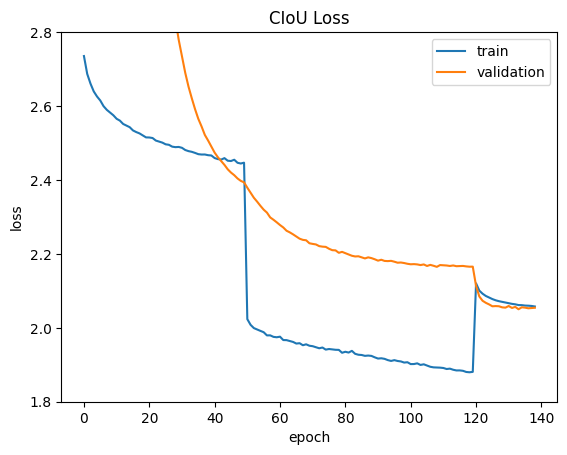

In [101]:
plt.plot(train_loss['ciou'])
plt.plot(test_loss['ciou'])
plt.ylim(1.8, 2.8)
plt.title('CIoU Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('training_log/coco/ciou_loss_v5.png', bbox_inches='tight')
plt.show()

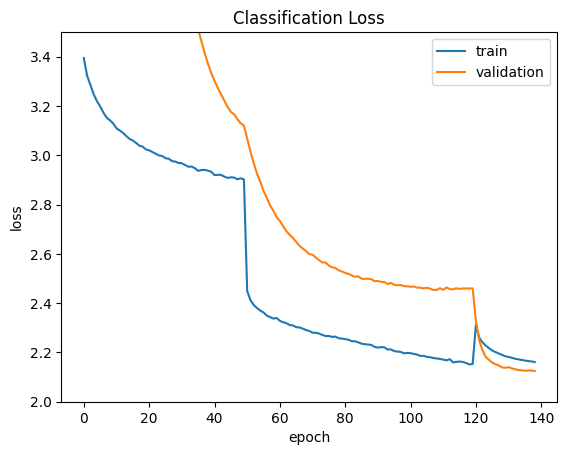

In [102]:
plt.plot(train_loss['cls'])
plt.plot(test_loss['cls'])
plt.ylim(2., 3.5)
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('training_log/coco/cls_loss_v5.png', bbox_inches='tight')
plt.show()

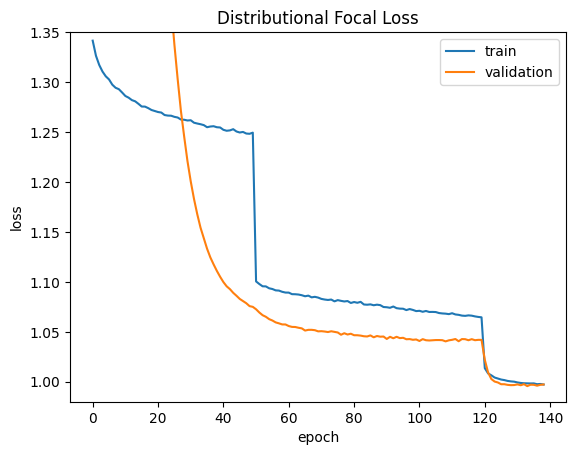

In [103]:
plt.plot(train_loss['dfl'])
plt.plot(test_loss['dfl'])
plt.ylim(0.98, 1.35)
plt.title('Distributional Focal Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('training_log/coco/dfl_loss_v5.png', bbox_inches='tight')
plt.show()

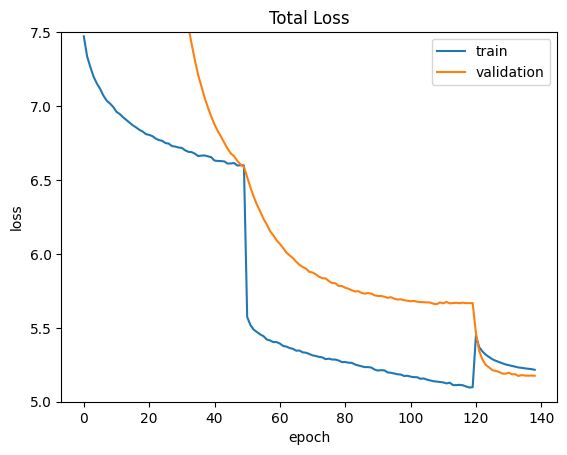

In [105]:
plt.plot(train_loss['total'])
plt.plot(test_loss['total'])
plt.ylim(5., 7.5)
plt.title('Total Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('training_log/coco/total_loss_v5.png', bbox_inches='tight')
plt.show()

In [60]:
image, bboxes, category_ids = next(iter(dataloader['val']))
trainer.model.eval()
pred = trainer.model(image.to(params['device']))
y = trainer.inference(pred)
print(pred[0].shape)
print(pred[1].shape)
print(pred[2].shape)
print(y.shape)

torch.Size([32, 97, 40, 40])
torch.Size([32, 97, 20, 20])
torch.Size([32, 97, 10, 10])
torch.Size([32, 85, 2100])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


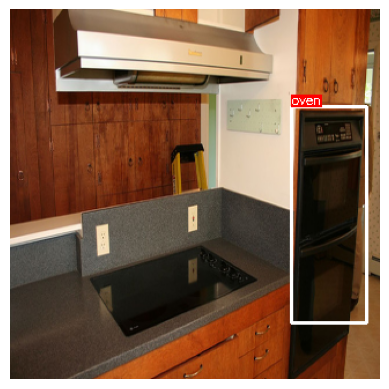

In [61]:
output = non_max_suppression(y, conf_thres=0.25, iou_thres=0.45, nc=len(classes)) # bbox xyxy, score, cls, nmask        
visualize_pred(image, output, classes)

## Import and evaluate trained model

In [35]:
#model_270_v3.pt
model = torch.load('checkpoint/coco/ema_140_v5.pt').to(params["device"])
model.eval()
print(summary(model, torch.zeros((1, 3, 640, 640)).to(params["device"]), show_input=True))

--------------------------------------------------------------------------
       Layer (type)           Input Shape         Param #     Tr. Param #
       ConvModule-1      [1, 3, 640, 640]             464               0
       ConvModule-2     [1, 16, 320, 320]           4,672               0
              C2f-3     [1, 32, 160, 160]           2,688               0
       ConvModule-4     [1, 32, 160, 160]          18,560               0
              C2f-5       [1, 64, 80, 80]          12,544               0
       ConvModule-6       [1, 64, 80, 80]          36,992               0
              C2f-7       [1, 64, 40, 40]          12,544               0
       ConvModule-8       [1, 64, 40, 40]          36,992               0
              C2f-9       [1, 64, 20, 20]          10,496               0
            SPPF-10       [1, 64, 20, 20]          20,736               0
        Upsample-11       [1, 64, 20, 20]               0               0
             C2f-12      [1, 128, 40,

In [36]:
validator = v8DetectionValidator(device=params['device'],
                   nclasses=len(classes), 
                   classes=classes)
metrics_names = ['P','R','mAP50','mAP50-95']
metric_monitor = MetricMonitor()
stream = tqdm(dataloader['val'], ncols=170)
result = {}

inference = Inference(nclasses=len(classes), stride=torch.tensor([8,16,32]), reg_max=params["reg_max"], device=params['device'])
        
dataset_bboxes = torch.tensor([])
dataset_cls = torch.tensor([])
pred_output = []

with torch.no_grad():
    for i, (image, bboxes, category_ids) in enumerate(stream, start=1):
        
        dataset_bboxes = torch.cat([dataset_bboxes, bboxes.to('cpu')], dim=0)
        dataset_cls = torch.cat([dataset_cls, category_ids.to('cpu')], dim=0)
        
        batch = {'batch_idx' : image.to(params['device'], non_blocking=True), 
                 'cls' : category_ids.to(params['device'], non_blocking=True), 
                 'bboxes' : bboxes.to(params['device'], non_blocking=True)}
        
        preds = model(batch['batch_idx'])
        y = inference(preds)
        output = non_max_suppression(y, conf_thres=0.001, iou_thres=0.6, max_det=300, nc=len(classes), multi_label=False)

        pred_output.extend(output)
                
        stream.set_description("{metric_monitor}".format(metric_monitor=metric_monitor))
        
batch = {'cls' : dataset_cls.to(params['device'], non_blocking=True), 
         'bboxes' : dataset_bboxes.to(params['device'], non_blocking=True)}
result = validator(pred_output, batch, depth=True, plots=True)
print(result)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:12<00:00, 12.30it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.3897677287137327, 'R': 0.24846566707161913, 'mAP50': 0.23148062743979994, 'mAP50-95': 0.12036285412361451}


## Import and evaluate YOLOv8n

In [157]:
# yolov8n ultralytics model
yolov8n = torch.load('yolov8n.pt', map_location=torch.device('cpu'))
trained_model = yolov8n['model']
trained_model = trained_model.to(torch.float32).to(params["device"])
trained_model.eval()
print(summary(trained_model, torch.zeros((1, 3, 320, 320)).to(params["device"]), show_input=True))

-----------------------------------------------------------------------------------------------------------
      Layer (type)                                             Input Shape         Param #     Tr. Param #
            Conv-1                                        [1, 3, 320, 320]             464               0
            Conv-2                                       [1, 16, 160, 160]           4,672               0
             C2f-3                                         [1, 32, 80, 80]           7,360               0
            Conv-4                                         [1, 32, 80, 80]          18,560               0
             C2f-5                                         [1, 64, 40, 40]          49,664               0
            Conv-6                                         [1, 64, 40, 40]          73,984               0
             C2f-7                                        [1, 128, 20, 20]         197,632               0
            Conv-8                  

In [158]:
validator = v8DetectionValidator(device=params['device'],
                   nclasses=len(classes), 
                   classes=classes)

metrics_names = ['P','R','mAP50','mAP50-95']
metric_monitor = MetricMonitor()
stream = tqdm(dataloader['val'], ncols=170)
result = {}

dataset_bboxes = torch.tensor([])
dataset_cls = torch.tensor([])
pred_output = []

with torch.no_grad():
    for i, (image, bboxes, category_ids) in enumerate(stream, start=1):
        
        dataset_bboxes = torch.cat([dataset_bboxes, bboxes.to('cpu')], dim=0)
        dataset_cls = torch.cat([dataset_cls, category_ids.to('cpu')], dim=0)
        
        batch = {'batch_idx' : image.to(params['device'], non_blocking=True), 
                 'cls' : category_ids.to(params['device'], non_blocking=True), 
                 'bboxes' : bboxes.to(params['device'], non_blocking=True)}
        
        y, preds = trained_model(batch['batch_idx'])
        output = non_max_suppression(y, conf_thres=0.001, iou_thres=0.6, max_det=300, nc=len(classes), multi_label=False)

        pred_output.extend(output)
    
        stream.set_description("YOLOv8n loss/metrics. {metric_monitor}".format(metric_monitor=metric_monitor))

batch = {'cls' : dataset_cls.to(params['device'], non_blocking=True), 
         'bboxes' : dataset_bboxes.to(params['device'], non_blocking=True)}
result = validator(pred_output, batch, depth=False, plots=True)

print(result)

YOLOv8n loss/metrics. : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:11<00:00, 14.05it/s]


{'seen': 4952, 'instances': 36335, 'P': 0.5939818844621731, 'R': 0.39754294003506196, 'mAP50': 0.42868501806073267, 'mAP50-95': 0.29393522479206136}


In [41]:
image, bboxes, category_ids = next(iter(dataloader['val']))
y, pred = trained_model(image.to(params['device']).half())
print(pred[0].shape)
print(pred[1].shape)
print(pred[2].shape)
print(y.shape)

torch.Size([16, 144, 80, 80])
torch.Size([16, 144, 40, 40])
torch.Size([16, 144, 20, 20])
torch.Size([16, 84, 8400])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


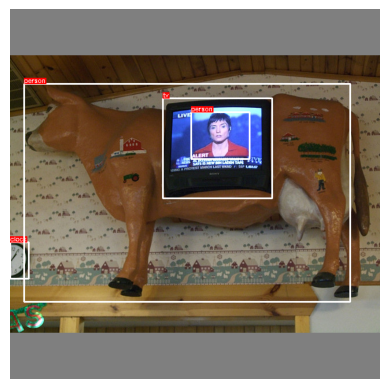

In [43]:
output = non_max_suppression(y) # bbox xyxy, score, cls
visualize_pred(image, output, classes)